In [1]:
#Imports
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import warnings
import scipy.stats as scs
import statistics
import math
import seaborn as sns
%matplotlib inline
import random
from collections import Counter
import seaborn as sns

<h2>Demog only - stationary</h2>

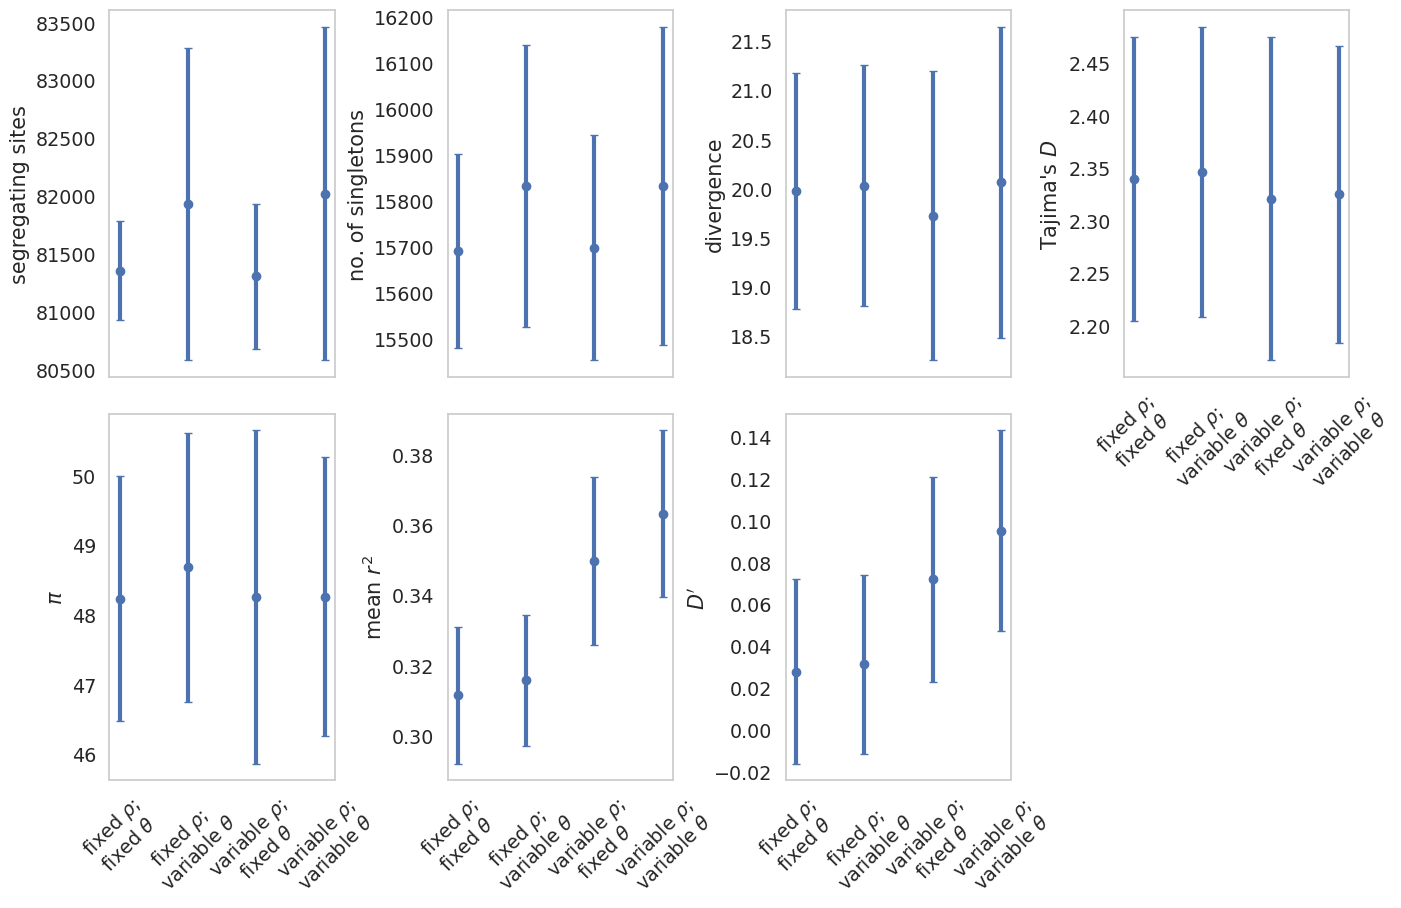

In [2]:
#####SUMMARY STATS#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty main df
df = pd.DataFrame()
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create empty list and dataframe
        lst = []
        sdf = pd.DataFrame()
        #Read in stats data and keep only relevant columns
        stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_only/stationary/rr_" + 
                            r + "_mu_" + m + 
                            ".stats", sep='\t', header=0)
        stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
        #Append mean and std of each statistic
        lst.append(stats.mean())
        lst.append(stats.std())
        #Convert list into dataframe
        sdf = pd.DataFrame(lst).T
        sdf['rr'] = r
        sdf['mu'] = m
        #Concatenate results with main df
        df = pd.concat([df, sdf])

#Create list of y labels
ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
#Create x axis
x = np.arange(4)+1
#Loop through y labels
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    #subset df for current statistic
    pdf = df[df.index==df.index[j]]
    #Plot mean of statistic, and std as errorbar
    plt.errorbar(x, pdf[0], pdf[1], fmt='o', lw=3, capsize=3, zorder=15)
    plt.ylabel(k)
    #Only set x tick labels for bottom plots
    if(j>=3):
        plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                       r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    else:
        plt.xticks([])
#Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.1)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS1.tiff', format='tiff', dpi=300, bbox_inches='tight')

In [6]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####
f_lst = []
#####GET FSC DF#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Read in fsc results data
        fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference/fsc/sfs_files/demog_only/stationary/rr_" + 
                            r + "_mu_" + m + ".bestlhoods", sep='\t', 
                            names=['Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
        #fsc gives an estimate of 2N, so divide by 2
        fsc['Ncurr'] = fsc.Ncurr/2
        #Remove any estimates <0 (ie failed inference)
        fsc = fsc[fsc.Ncurr>0]
        #Append mean, std, min and max of Ncurr as a list to main list
        lst.append([r, m, fsc.Ncurr.mean(), fsc.Ncurr.std(), fsc.Ncurr.quantile(0.25), fsc.Ncurr.quantile(0.75)])
        f_lst.append(fsc)
fsc_df = pd.DataFrame(lst, columns=['rr', 'mu', 'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max'])

In [7]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####

#####GET DADI DF#####
d_lst = []
#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create df for storing lowest log likelihood inference for each rep
        ddf = pd.DataFrame()
        #Loop through reps
        for rep in range(1, 11):
            dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_only/stationary/rr_" + 
                            r + "_mu_" + m + "/1Mb_run" + str(rep) + ".txt", sep='\t', 
                               names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
            #Identify inference with lowest log likelihood
            dadi = dadi[dadi.LogL==dadi.LogL.min()]
            #Add rep info
            dadi['rep'] = rep
            #Concatenate with main dataframe
            ddf = pd.concat([ddf,dadi])
        #Keep only viable inferences
        ddf = ddf[(ddf.Nu_opt > 0.02)]
        ddf['Ncurr'] = ddf.Nu_opt * 7000
        #Append mean, std, min and max of Ncurr as a list to main list
        lst.append([r, m, ddf.Ncurr.mean(), ddf.Ncurr.std(), ddf.Ncurr.quantile(0.25), ddf.Ncurr.quantile(0.75)])
        d_lst.append(ddf)
dadi_df = pd.DataFrame(lst, columns=['rr', 'mu', 'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max'])

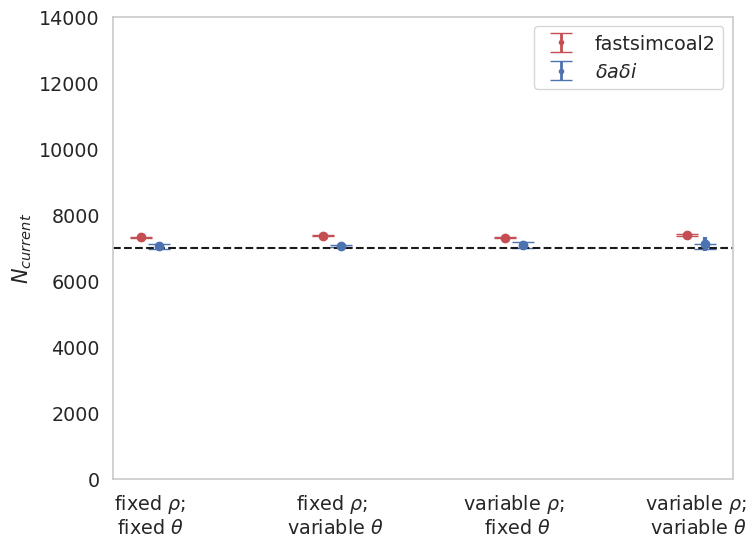

In [97]:
sns.set(rc={'figure.figsize':(8,6),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)

dadi_df['method'] = 'dadi'
fsc_df['method'] = 'FSC2'

x = np.arange(4)+1
plt.errorbar([i-0.05 for i in x], fsc_df.Ncurr_mean, fsc_df.Ncurr_std, fmt='or', lw=3)
plt.errorbar([i-0.05 for i in x], fsc_df.Ncurr_mean, 
             [fsc_df.Ncurr_mean - fsc_df.Ncurr_min, fsc_df.Ncurr_max - fsc_df.Ncurr_mean],
             fmt='.r', ecolor='r', lw=2, capsize=8, label='fastsimcoal2')

plt.errorbar([i+0.05 for i in x], dadi_df.Ncurr_mean, dadi_df.Ncurr_std, fmt='ob', lw=3)
plt.errorbar([i+0.05 for i in x], dadi_df.Ncurr_mean, 
             [dadi_df.Ncurr_mean - dadi_df.Ncurr_min, dadi_df.Ncurr_max - dadi_df.Ncurr_mean],
             fmt='.b', ecolor='b', lw=2, capsize=8, label=r'$\delta$$a$$\delta$$i$')

plt.ylim([0, 14000])
plt.axhline(y=7000, color='k', linestyle='--')

plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
               r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
               r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
               r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=0)
plt.ylabel(r'$N_{current}$')
plt.legend()

plt.savefig('/home/vivak/rr_mu_demog_inference/plots/fig1.tiff', format='tiff', dpi=300)

<h2>Demog Only - Expansion</h2>

In [29]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####

#####GET FSC DF#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Read in fsc results data
        fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference//fsc/sfs_files/demog_only/expansion/rr_" + 
                            r + "_mu_" + m + ".bestlhoods", sep='\t', 
                            names=['Ncurr', 'Nanc', 'tanc', 'Nanc/Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
        #fsc gives an estimate of 2N, so divide by 2
        for i in ['Ncurr', 'Nanc']:
            fsc[i] = fsc[i]/2
        #Remove any estimates <0 (ie failed inference)
        fsc = fsc[(fsc.Ncurr>1000) & (fsc.Nanc>1000) & (fsc.tanc>1000)]
        #Append mean, std, min and max of Ncurr as a list to main list
        lst.append([r, m, 
                    fsc.Ncurr.mean(), fsc.Ncurr.std(), fsc.Ncurr.quantile(0.25), fsc.Ncurr.quantile(0.75),
                   fsc.Nanc.mean(), fsc.Nanc.std(), fsc.Nanc.quantile(0.25), fsc.Nanc.quantile(0.75),
                   fsc.tanc.mean(), fsc.tanc.std(), fsc.tanc.quantile(0.25), fsc.tanc.quantile(0.75),])

fsc_df = pd.DataFrame(lst, columns=['rr', 'mu', 
                                    'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max',
                                   'Nanc_mean', 'Nanc_std', 'Nanc_min', 'Nanc_max',
                                   'tanc_mean', 'tanc_std', 'tanc_min', 'tanc_max'])

In [30]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####

#####GET DADI DF#####

#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create df for storing lowest log likelihood inference for each rep
        ddf = pd.DataFrame()
        #Loop through reps
        for rep in range(1, 11):
            dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_only/expansion/rr_" + 
                            r + "_mu_" + m + "/1Mb_run" + str(rep) + ".txt", sep='\t', 
                               names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
            #Identify inference with lowest log likelihood
            dadi = dadi[dadi.LogL==dadi.LogL.min()]
            #Add rep info
            dadi['rep'] = rep
            #Concatenate with main dataframe
            ddf = pd.concat([ddf,dadi])
        #Keep only viable inferences
        ddf = ddf[(ddf.Nu_opt > 0.02) & (ddf.Nu_opt <2.75) &
                 (ddf.t_opt > 0.02) & (ddf.t_opt <2.75)]
        ddf['Ncurr'] = ddf.Nu_opt * 7000
        ddf['tanc'] = ddf.t_opt * 7000 * 2
        #Append mean, std, min and max of Ncurr as a list to main list
        lst.append([r, m, 
                    ddf.Ncurr.mean(), ddf.Ncurr.std(), ddf.Ncurr.quantile(0.25), ddf.Ncurr.quantile(0.75),
                   ddf.tanc.mean(), ddf.tanc.std(), ddf.tanc.quantile(0.25), ddf.tanc.quantile(0.75)])

dadi_df = pd.DataFrame(lst, columns=['rr', 'mu', 
                                     'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max',
                                    'tanc_mean', 'tanc_std', 'tanc_min', 'tanc_max'])

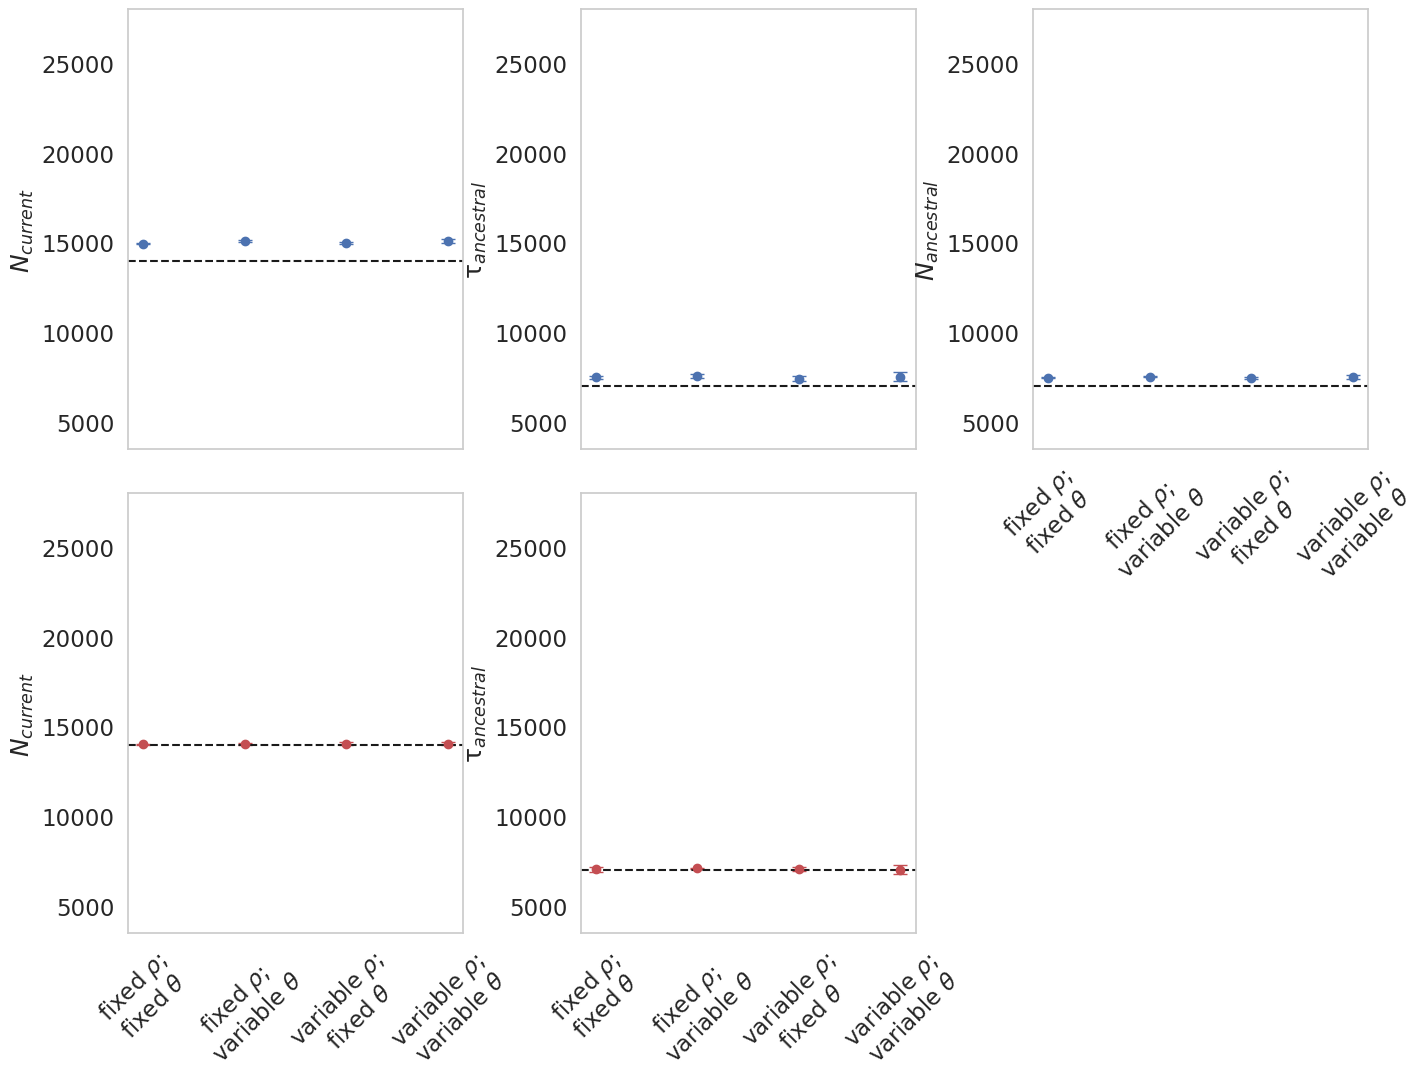

In [31]:
sns.set(rc={'figure.figsize':(16,12),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
params = ['Ncurr', 'tanc', 'Nanc']
labels = [r'$N_{current}$', u'\u03C4' + r'$_{ancestral}$', r'$N_{ancestral}$']
thresholds = [14000, 7000, 7000]
ylims = [3500, 28000]
for i, j in enumerate(params):
    plt.subplot(2,3,i+1)
    #Create x axis
    x = np.arange(4)+1
    plt.errorbar(x, fsc_df[j + '_mean'], fsc_df[j + '_std'], fmt='ob', lw=3, capsize=5)
#     plt.errorbar(x, fsc_df[j + '_mean'], [fsc_df[j + '_mean'] - fsc_df[j + '_min'],fsc_df[j + '_max'] - fsc_df[j + '_mean']],
#                  fmt='.b', ecolor='blue', lw=1, capsize=5)
    
    plt.axhline(y=thresholds[i], color='k', linestyle='--')
    if(i==2):
        plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                       r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    else:
        plt.xticks(x, ['','','',''])
    plt.ylabel(labels[i])
    plt.ylim(ylims)


params = ['Ncurr', 'tanc']
labels = [r'$N_{current}$', u'\u03C4' + r'$_{ancestral}$']
for i, j in enumerate(params):
    plt.subplot(2,3,i+4)
    #Create x axis
    x = np.arange(4)+1
    plt.errorbar(x, dadi_df[j + '_mean'], dadi_df[j + '_std'], fmt='or', lw=3, capsize=5)
#     plt.errorbar(x, dadi_df[j + '_mean'], [dadi_df[j + '_mean'] - dadi_df[j + '_min'],dadi_df[j + '_max'] - dadi_df[j + '_mean']],
#                  fmt='.r', ecolor='red', lw=1, capsize=5)
    
    plt.axhline(y=thresholds[i], color='k', linestyle='--')
    plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                   r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                   r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                   r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    plt.ylabel(labels[i])
    plt.ylim(ylims)
   
    
plt.subplots_adjust(wspace=0.35, hspace=0.1)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS2.tiff', format='tiff', dpi=300, bbox_inches='tight')

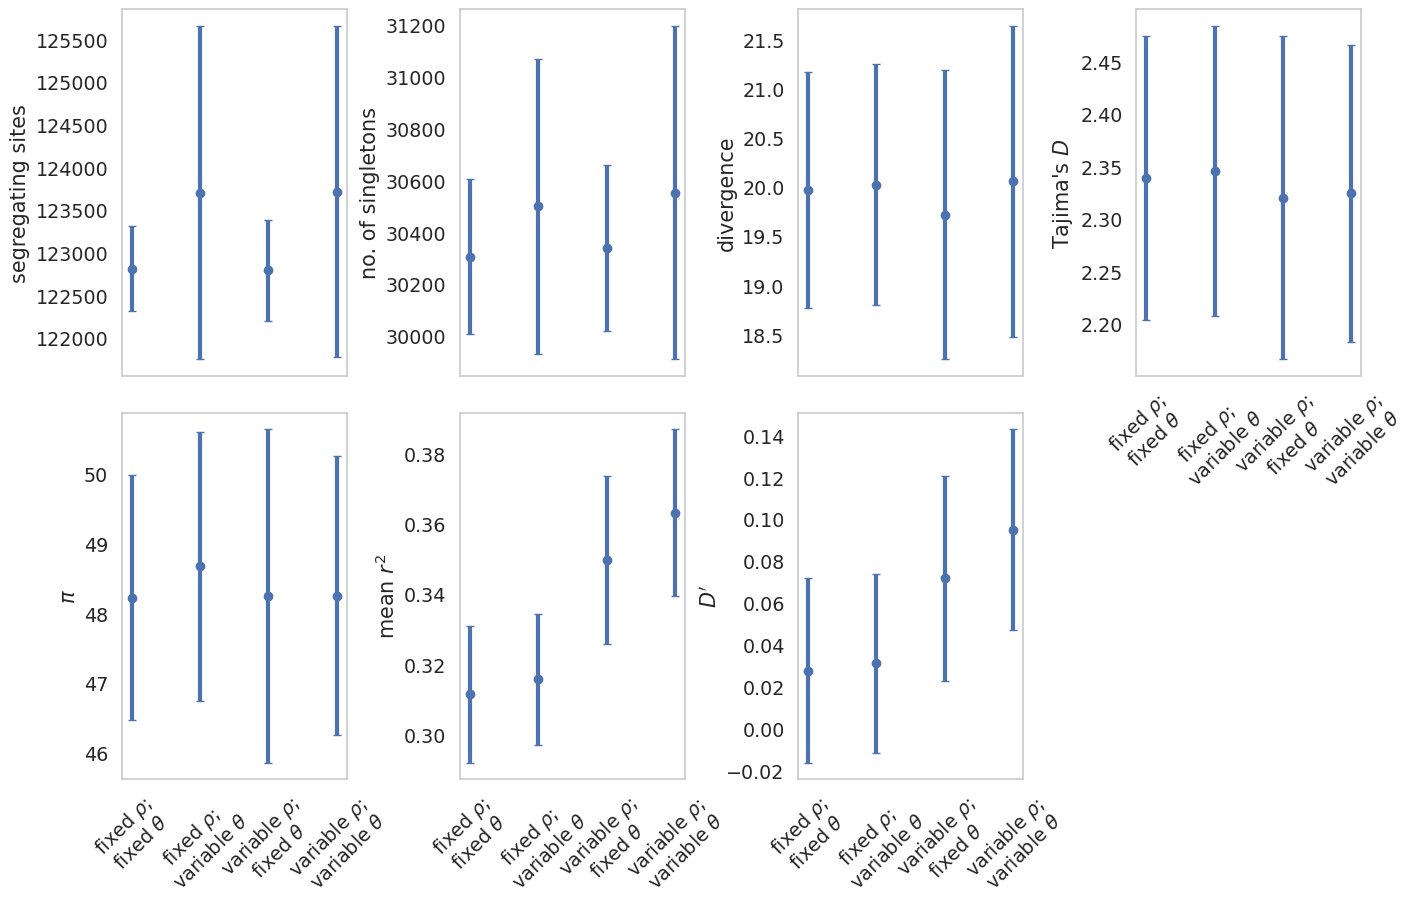

In [3]:
#####SUMMARY STATS#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty main df
df = pd.DataFrame()
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create empty list and dataframe
        lst = []
        sdf = pd.DataFrame()
        #Read in stats data and keep only relevant columns
        stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_only/expansion/rr_" + 
                            r + "_mu_" + m + 
                            ".stats", sep='\t', header=0)
        stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
        #Append mean and std of each statistic
        lst.append(stats.mean())
        lst.append(stats.std())
        #Convert list into dataframe
        sdf = pd.DataFrame(lst).T
        sdf['rr'] = r
        sdf['mu'] = m
        #Concatenate results with main df
        df = pd.concat([df, sdf])

#Create list of y labels
ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
#Create x axis
x = np.arange(4)+1
#Loop through y labels
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    #subset df for current statistic
    pdf = df[df.index==df.index[j]]
    #Plot mean of statistic, and std as errorbar
    plt.errorbar(x, pdf[0], pdf[1], fmt='o', lw=3, capsize=3, zorder=15)
    plt.ylabel(k)
    #Only set x tick labels for bottom plots
    if(j>=3):
        plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                       r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    else:
        plt.xticks([])
#Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.1)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS3.tiff', format='tiff', dpi=300, bbox_inches='tight')

<h2>Demog only - contraction </h2>

In [16]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####

#####GET FSC DF#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Read in fsc results data
        fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference/fsc/sfs_files/demog_only/contraction/rr_" + 
                            r + "_mu_" + m + ".bestlhoods", sep='\t', 
                            names=['Ncurr', 'Nanc', 'tanc', 'Nanc/Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
        #fsc gives an estimate of 2N, so divide by 2
        for i in ['Ncurr', 'Nanc']:
            fsc[i] = fsc[i]/2
        #Remove any estimates <0 (ie failed inference)
        fsc = fsc[(fsc.Ncurr>1000) & (fsc.Nanc>1000) & (fsc.tanc>1000)]
        #Append mean, std, min and max of Ncurr as a list to main list
        lst.append([r, m, 
                    fsc.Ncurr.mean(), fsc.Ncurr.std(), fsc.Ncurr.quantile(0.25), fsc.Ncurr.quantile(0.75),
                   fsc.Nanc.mean(), fsc.Nanc.std(), fsc.Nanc.quantile(0.25), fsc.Nanc.quantile(0.75),
                   fsc.tanc.mean(), fsc.tanc.std(), fsc.tanc.quantile(0.25), fsc.tanc.quantile(0.75),])

fsc_df = pd.DataFrame(lst, columns=['rr', 'mu', 
                                    'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max',
                                   'Nanc_mean', 'Nanc_std', 'Nanc_min', 'Nanc_max',
                                   'tanc_mean', 'tanc_std', 'tanc_min', 'tanc_max'])

In [17]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####

#####GET DADI DF#####

#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create df for storing lowest log likelihood inference for each rep
        ddf = pd.DataFrame()
        #Loop through reps
        for rep in range(1, 11):
            dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_only/contraction/rr_" + 
                            r + "_mu_" + m + "/1Mb_run" + str(rep) + ".txt", sep='\t', 
                               names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
            #Identify inference with lowest log likelihood
            dadi = dadi[dadi.LogL==dadi.LogL.min()]
            #Add rep info
            dadi['rep'] = rep
            #Concatenate with main dataframe
            ddf = pd.concat([ddf,dadi])
        #Keep only viable inferences
        ddf = ddf[(ddf.Nu_opt > 0.02) & (ddf.Nu_opt <2.75) &
                 (ddf.t_opt > 0.02) & (ddf.t_opt <2.75)]
        ddf['Ncurr'] = ddf.Nu_opt * 7000
        ddf['tanc'] = ddf.t_opt * 7000 * 2
        #Append mean, std, min and max of Ncurr as a list to main list
        lst.append([r, m, 
                    ddf.Ncurr.mean(), ddf.Ncurr.std(), ddf.Ncurr.quantile(0.25), ddf.Ncurr.quantile(0.75),
                   ddf.tanc.mean(), ddf.tanc.std(), ddf.tanc.quantile(0.25), ddf.tanc.quantile(0.75)])

dadi_df = pd.DataFrame(lst, columns=['rr', 'mu', 
                                     'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max',
                                    'tanc_mean', 'tanc_std', 'tanc_min', 'tanc_max'])

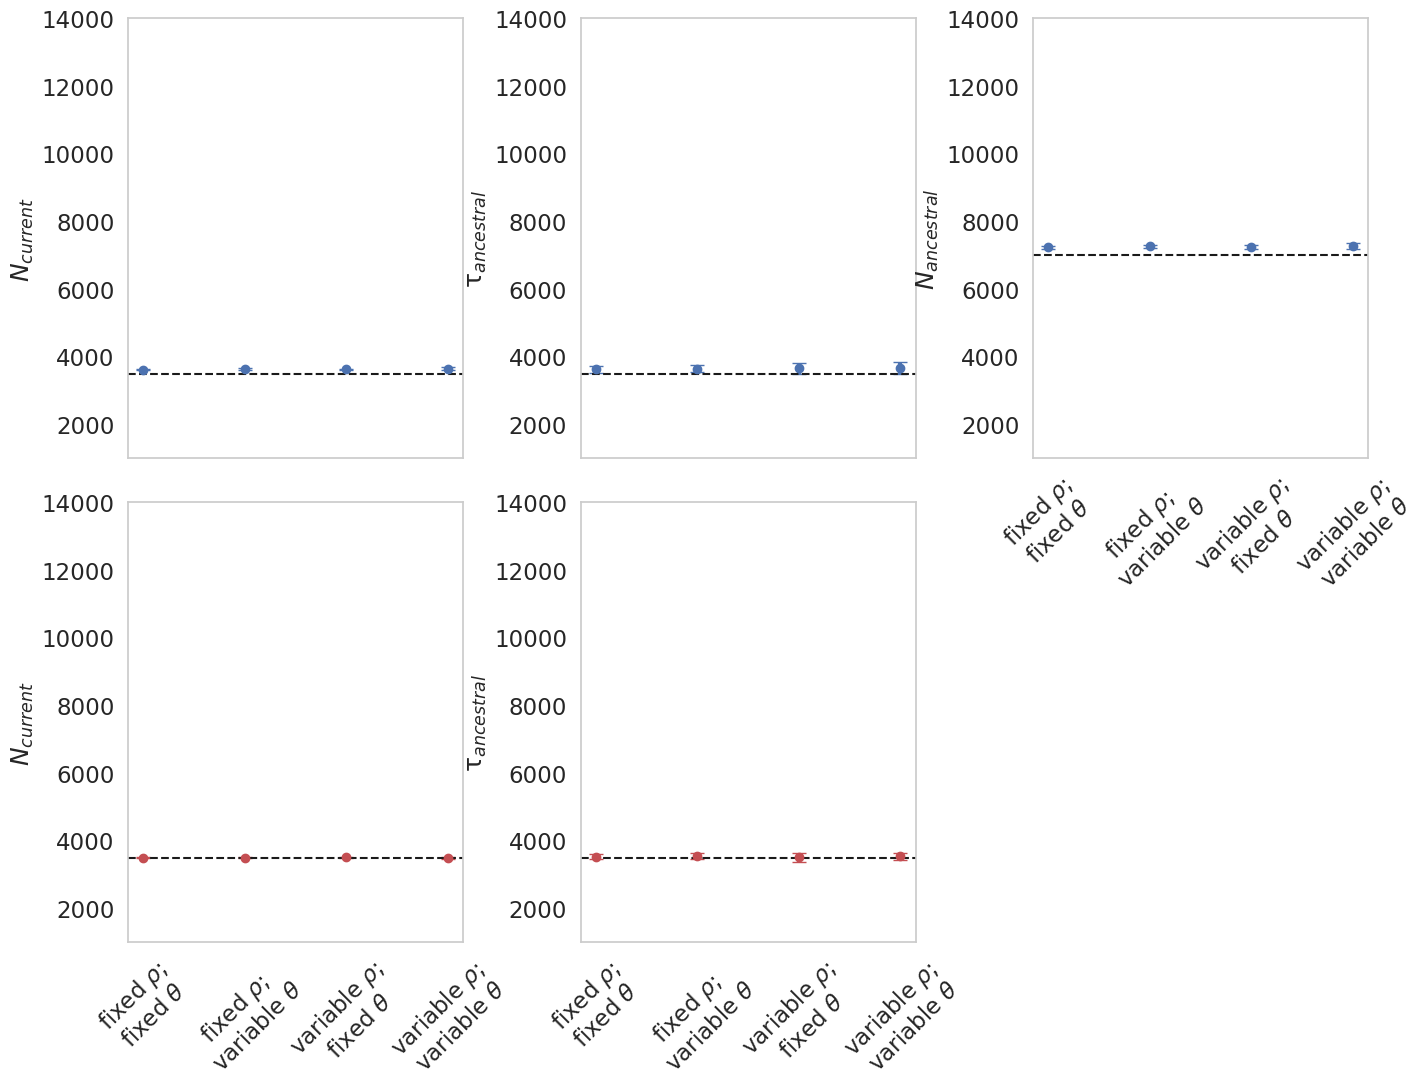

In [18]:
sns.set(rc={'figure.figsize':(16,12),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
params = ['Ncurr', 'tanc', 'Nanc']
labels = [r'$N_{current}$', u'\u03C4' + r'$_{ancestral}$', r'$N_{ancestral}$']
thresholds = [3500, 3500, 7000]
ylims = [1000, 14000]
for i, j in enumerate(params):
    plt.subplot(2,3,i+1)
    #Create x axis
    x = np.arange(4)+1
    plt.errorbar(x, fsc_df[j + '_mean'], fsc_df[j + '_std'], fmt='ob', lw=3, capsize=5)
#     plt.errorbar(x, fsc_df[j + '_mean'], [fsc_df[j + '_mean'] - fsc_df[j + '_min'],fsc_df[j + '_max'] - fsc_df[j + '_mean']],
#                  fmt='.b', ecolor='blue', lw=1, capsize=5)
    
    plt.axhline(y=thresholds[i], color='k', linestyle='--')
    if(i==2):
        plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                       r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    else:
        plt.xticks(x, ['','','',''])
    plt.ylabel(labels[i])
    plt.ylim(ylims)


params = ['Ncurr', 'tanc']
labels = [r'$N_{current}$', u'\u03C4' + r'$_{ancestral}$']
for i, j in enumerate(params):
    plt.subplot(2,3,i+4)
    #Create x axis
    x = np.arange(4)+1
    plt.errorbar(x, dadi_df[j + '_mean'], dadi_df[j + '_std'], fmt='or', lw=3, capsize=5)
#     plt.errorbar(x, dadi_df[j + '_mean'], [dadi_df[j + '_mean'] - dadi_df[j + '_min'],dadi_df[j + '_max'] - dadi_df[j + '_mean']],
#                  fmt='.r', ecolor='red', lw=1, capsize=5)
    
    plt.axhline(y=thresholds[i], color='k', linestyle='--')
    plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                   r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                   r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                   r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    plt.ylabel(labels[i])
    plt.ylim(ylims)
   
    
plt.subplots_adjust(wspace=0.35, hspace=0.1)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS4.tiff', format='tiff', dpi=300, bbox_inches='tight')

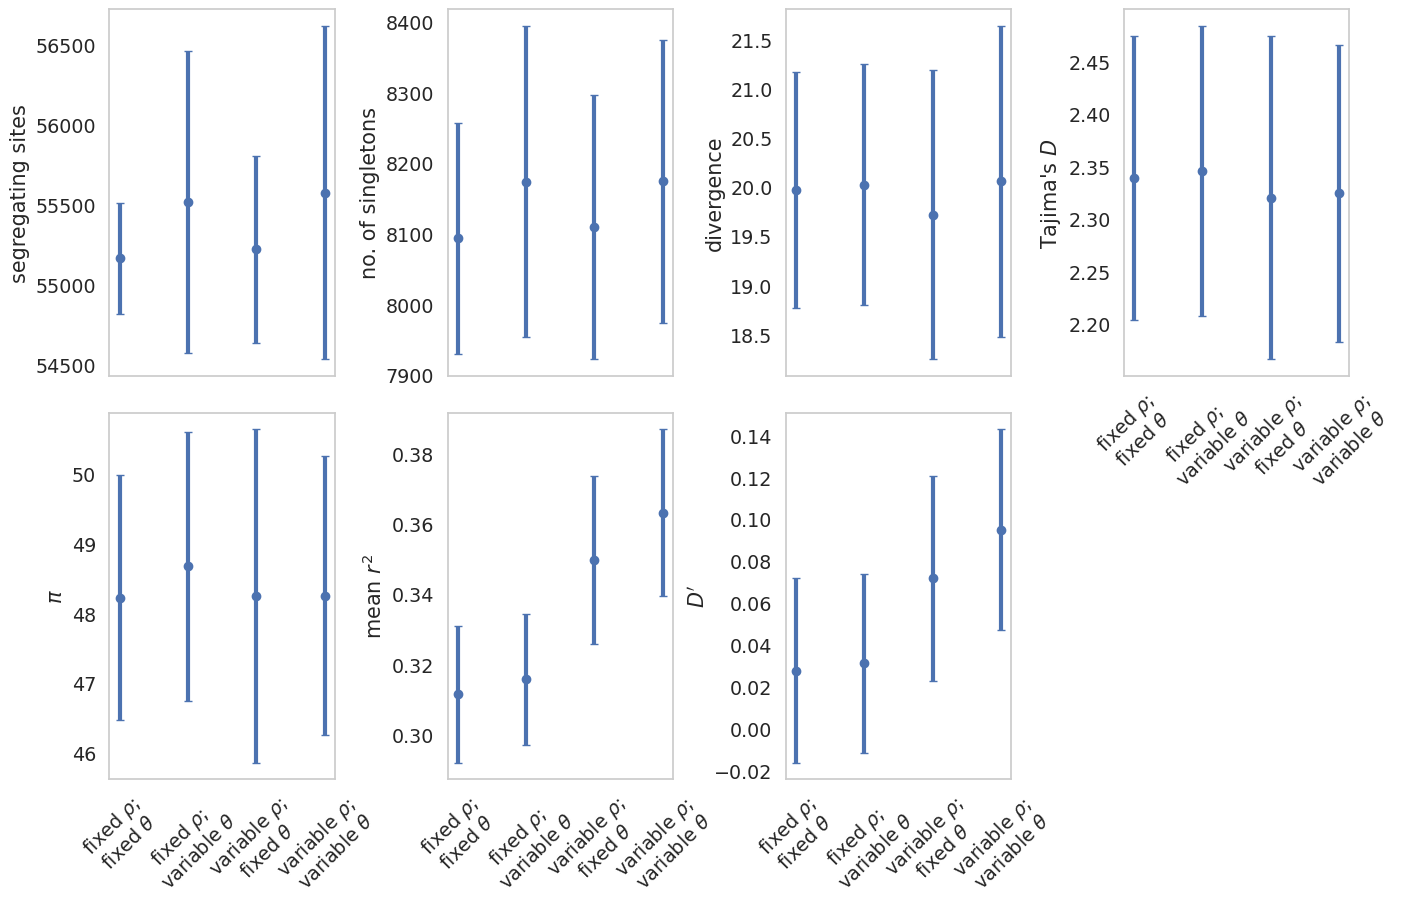

In [4]:
#####SUMMARY STATS#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty main df
df = pd.DataFrame()
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create empty list and dataframe
        lst = []
        sdf = pd.DataFrame()
        #Read in stats data and keep only relevant columns
        stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_only/contraction/rr_" + 
                            r + "_mu_" + m + 
                            ".stats", sep='\t', header=0)
        stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
        #Append mean and std of each statistic
        lst.append(stats.mean())
        lst.append(stats.std())
        #Convert list into dataframe
        sdf = pd.DataFrame(lst).T
        sdf['rr'] = r
        sdf['mu'] = m
        #Concatenate results with main df
        df = pd.concat([df, sdf])

#Create list of y labels
ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
#Create x axis
x = np.arange(4)+1
#Loop through y labels
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    #subset df for current statistic
    pdf = df[df.index==df.index[j]]
    #Plot mean of statistic, and std as errorbar
    plt.errorbar(x, pdf[0], pdf[1], fmt='o', lw=3, capsize=3, zorder=15)
    plt.ylabel(k)
    #Only set x tick labels for bottom plots
    if(j>=3):
        plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                       r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    else:
        plt.xticks([])
#Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.1)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS5.tiff', format='tiff', dpi=300, bbox_inches='tight')

<h2>Demog only - 99% contraction</h2>

In [24]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####

#####GET FSC DF#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Read in fsc results data
        fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference/fsc/sfs_files/demog_only/cc/rr_" + 
                            r + "_mu_" + m + ".bestlhoods", sep='\t', 
                            names=['Ncurr', 'Nanc', 'tanc', 'Nanc/Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
        #fsc gives an estimate of 2N, so divide by 2
        for i in ['Ncurr', 'Nanc']:
            fsc[i] = fsc[i]/2
        #Remove any estimates <0 (ie failed inference)
        #fsc = fsc[(fsc.Ncurr>0) & (fsc.Nanc>1000) & (fsc.Nanc<35000) & (fsc.tanc>0)]
        #Append mean, std, min and max of Ncurr as a list to main list
#         lst.append([r, m, 
#                     fsc.Ncurr.mean(), fsc.Ncurr.std(), fsc.Ncurr.quantile(0.05), fsc.Ncurr.quantile(0.95),
#                    fsc.Nanc.mean(), fsc.Nanc.std(), fsc.Nanc.quantile(0.05), fsc.Nanc.quantile(0.95),
#                    fsc.tanc.mean(), fsc.tanc.std(), fsc.tanc.quantile(0.05), fsc.tanc.quantile(0.95)])
        
        lst.append([r, m, 
                    fsc.Ncurr.mean(), fsc.Ncurr.std(), fsc.Ncurr.quantile(0.25), fsc.Ncurr.quantile(0.75),
                   fsc.Nanc.mean(), fsc.Nanc.std(), fsc.Nanc.quantile(0.25), fsc.Nanc.quantile(0.75),
                   fsc.tanc.mean(), fsc.tanc.std(), fsc.tanc.quantile(0.25), fsc.tanc.quantile(0.75),])

fsc_df = pd.DataFrame(lst, columns=['rr', 'mu', 
                                    'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max',
                                   'Nanc_mean', 'Nanc_std', 'Nanc_min', 'Nanc_max',
                                   'tanc_mean', 'tanc_std', 'tanc_min', 'tanc_max'])

fsc_df['Ncurr_0.75'] = np.where(fsc_df['Ncurr_max']>fsc_df['Ncurr_mean'],
                                fsc_df['Ncurr_max'] - fsc_df['Ncurr_mean'],
                                fsc_df['Ncurr_max'])

fsc_df['Nanc_0.75'] = np.where(fsc_df['Nanc_max']>fsc_df['Nanc_mean'],
                                fsc_df['Nanc_max'] - fsc_df['Ncurr_mean'],
                                fsc_df['Nanc_max'])

fsc_df['tanc_0.75'] = np.where(fsc_df['tanc_max']>fsc_df['tanc_mean'],
                                fsc_df['tanc_max'] - fsc_df['tanc_mean'],
                                fsc_df['tanc_max'])

In [25]:
#####PLOT OF FSC AND DADI INFERENCE FOR SINGLE DEMOGRAPHIC SCENARIO#####

#####GET DADI DF#####

#Create empty list to store nested lists
lst = []
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create df for storing lowest log likelihood inference for each rep
        ddf = pd.DataFrame()
        #Loop through reps
        for rep in range(1, 11):
            dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_only/cc/rr_" + 
                            r + "_mu_" + m + "/1Mb_run" + str(rep) + ".txt", sep='\t', 
                               names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
            #Identify inference with lowest log likelihood
            dadi = dadi[dadi.LogL==dadi.LogL.min()]
            #Add rep info
            dadi['rep'] = rep
            #Concatenate with main dataframe
            ddf = pd.concat([ddf,dadi])
        #Keep only viable inferences
        ddf = ddf[(ddf.Nu_opt <2.75) & (ddf.t_opt <2.75)]
        ddf['Ncurr'] = ddf.Nu_opt * 7000
        ddf['tanc'] = ddf.t_opt * 7000 * 2
        #Append mean, std, min and max of Ncurr as a list to main list
        lst.append([r, m, 
                    ddf.Ncurr.mean(), ddf.Ncurr.std(), ddf.Ncurr.quantile(0.25), ddf.Ncurr.quantile(0.75),
                   ddf.tanc.mean(), ddf.tanc.std(), ddf.tanc.quantile(0.25), ddf.tanc.quantile(0.75)])

dadi_df = pd.DataFrame(lst, columns=['rr', 'mu', 
                                     'Ncurr_mean', 'Ncurr_std', 'Ncurr_min', 'Ncurr_max',
                                    'tanc_mean', 'tanc_std', 'tanc_min', 'tanc_max'])

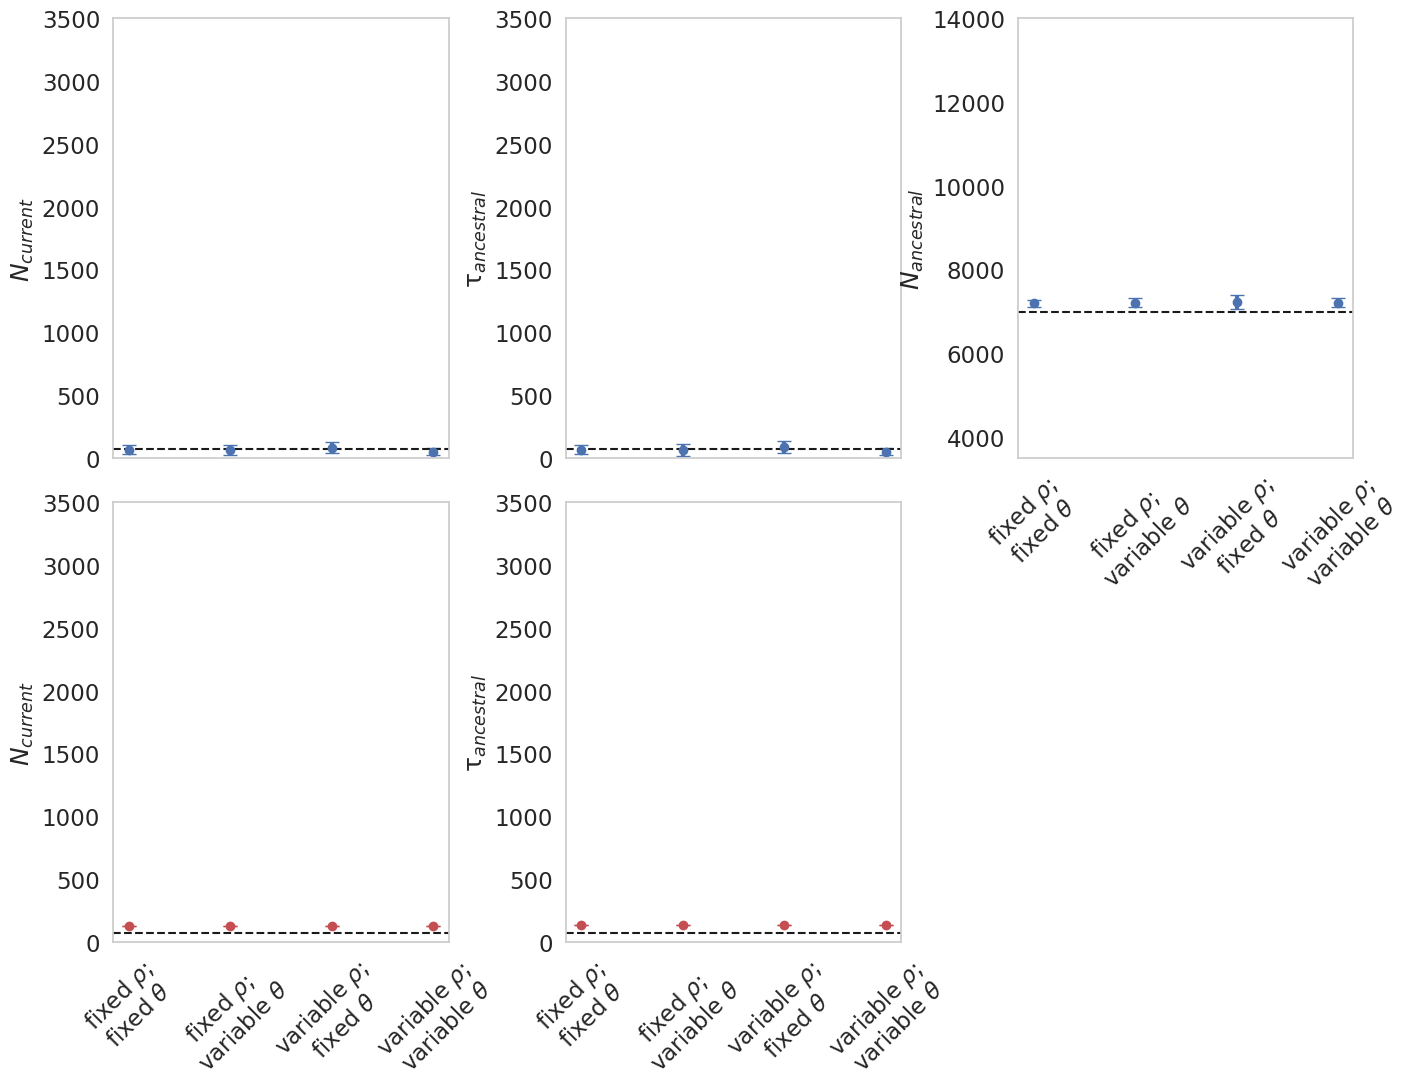

In [26]:
sns.set(rc={'figure.figsize':(16,12),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
params = ['Ncurr', 'tanc', 'Nanc']
labels = [r'$N_{current}$', u'\u03C4' + r'$_{ancestral}$', r'$N_{ancestral}$']
thresholds = [70, 70, 7000]
ylims = [0, 3500]
for i, j in enumerate(params):
    plt.subplot(2,3,i+1)
    #Create x axis
    x = np.arange(4)+1
    plt.errorbar(x, fsc_df[j + '_mean'], fsc_df[j + '_std'], fmt='ob', lw=3, capsize=5)
#     plt.errorbar(x, fsc_df[j + '_mean'], [fsc_df[j + '_mean'] - fsc_df[j + '_min'],fsc_df[j + '_max'] - fsc_df[j + '_mean']],
#                  fmt='.b', ecolor='blue', lw=1, capsize=5)
    
    plt.axhline(y=thresholds[i], color='k', linestyle='--')
    if(i==2):
        plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                       r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    else:
        plt.xticks(x, ['','','',''])
    plt.ylabel(labels[i])
    if(j=='Nanc'):
        plt.ylim([3500, 14000])
    else:
        plt.ylim(ylims)


params = ['Ncurr', 'tanc']
labels = [r'$N_{current}$', u'\u03C4' + r'$_{ancestral}$']
for i, j in enumerate(params):
    plt.subplot(2,3,i+4)
    #Create x axis
    x = np.arange(4)+1
    plt.errorbar(x, dadi_df[j + '_mean'], dadi_df[j + '_std'], fmt='or', lw=3, capsize=5)
#     plt.errorbar(x, dadi_df[j + '_mean'], [dadi_df[j + '_mean'] - dadi_df[j + '_min'],dadi_df[j + '_max'] - dadi_df[j + '_mean']],
#                  fmt='.r', ecolor='red', lw=1, capsize=5)
    
    plt.axhline(y=thresholds[i], color='k', linestyle='--')
    plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                   r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                   r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                   r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    plt.ylabel(labels[i])
    plt.ylim(ylims)
   
    
plt.subplots_adjust(wspace=0.35, hspace=0.1)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS6.tiff', format='tiff', dpi=300, bbox_inches='tight')

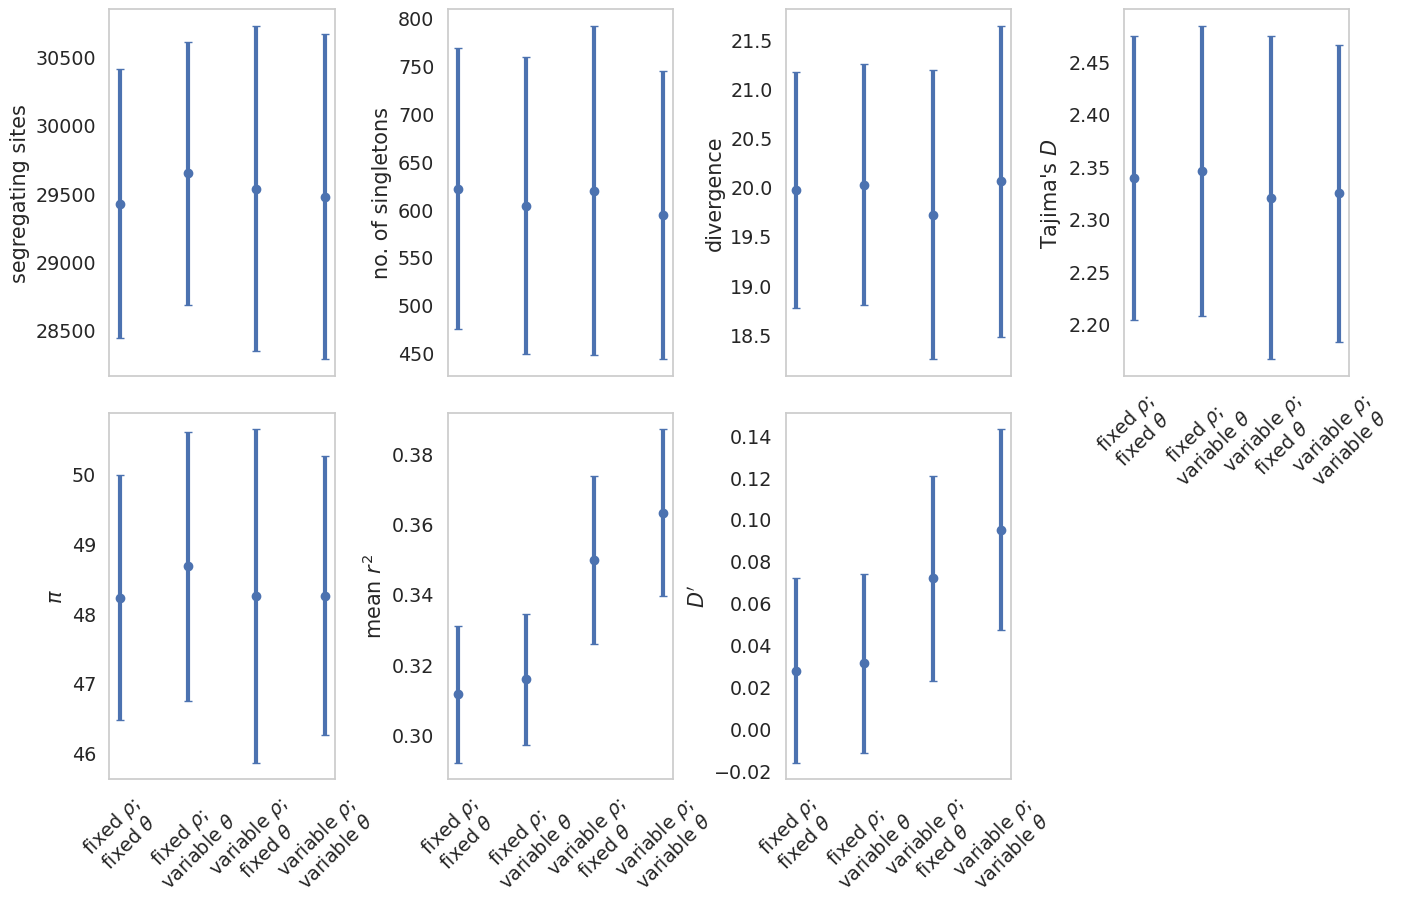

In [5]:
#####SUMMARY STATS#####
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
#Create empty main df
df = pd.DataFrame()
#Loop through variable and fixed rates
for r in rr:
    for m in mu:
        #Create empty list and dataframe
        lst = []
        sdf = pd.DataFrame()
        #Read in stats data and keep only relevant columns
        stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_only/cc/rr_" + 
                            r + "_mu_" + m + 
                            ".stats", sep='\t', header=0)
        stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
        #Append mean and std of each statistic
        lst.append(stats.mean())
        lst.append(stats.std())
        #Convert list into dataframe
        sdf = pd.DataFrame(lst).T
        sdf['rr'] = r
        sdf['mu'] = m
        #Concatenate results with main df
        df = pd.concat([df, sdf])

#Create list of y labels
ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
#Create x axis
x = np.arange(4)+1
#Loop through y labels
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    #subset df for current statistic
    pdf = df[df.index==df.index[j]]
    #Plot mean of statistic, and std as errorbar
    plt.errorbar(x, pdf[0], pdf[1], fmt='o', lw=3, capsize=3, zorder=15)
    plt.ylabel(k)
    #Only set x tick labels for bottom plots
    if(j>=3):
        plt.xticks(x, [r'fixed ' + u'$\u03C1$;' + '\nfixed ' + r'$\theta$', 
                       r'fixed ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n fixed ' + r'$\theta$',
                       r'variable ' + u'$\u03C1$;' + '\n variable ' + r'$\theta$'], rotation=45)
    else:
        plt.xticks([])
#Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.1)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS7.tiff', format='tiff', dpi=300, bbox_inches='tight')

<h2>Demog DFE - stationary</h2>

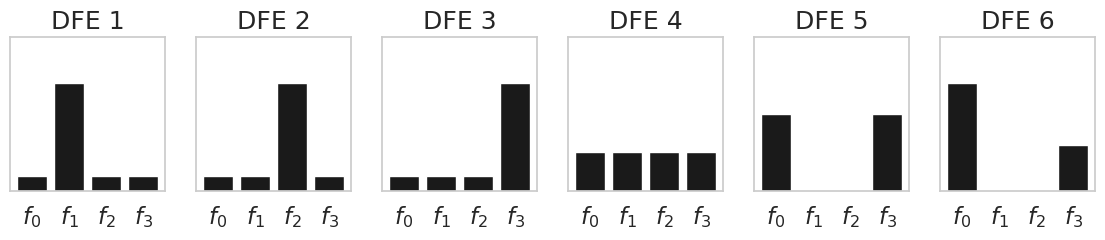

In [21]:
DFE = [[0.1,0.7,0.1,0.1],
      [0.1,0.1,0.7,0.1],
      [0.1,0.1,0.1,0.7],
      [0.25,0.25,0.25,0.25],
      [0.5,0,0,0.5],
      [0.7,0,0,0.3]]

sns.set(rc={'figure.figsize':(14,2),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
x = [a for a in range(0,4)]
for i,j in enumerate(DFE):
    plt.subplot(1,6,i+1)
    plt.bar(x=x, height=j, color='k')
    plt.ylim([0,1])
#     if(i!=0):
#         plt.yticks([])
#     else:
#         plt.yticks([0, 0.5, 1])
#         plt.ylabel('Frequency', rotation=90)
    plt.yticks([])
#     plt.xticks([-1, 0, 1.25, 2.5], 
#                [r'$0 \leq 2N_es < 0.001$', r'$0.001 \leq 2N_es < 0.01$', r'$0.01 \leq 2N_es < 0.1$', r'$0.1 \leq 2N_es < 1$'], 
#            rotation=60)
    plt.xticks([0,1,2,3], [r'$f_0$', r'$f_1$', r'$f_2$', r'$f_3$'])
    plt.title('DFE ' + str(i+1))
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/fig2f.tiff', format='tiff', dpi=300, bbox_inches='tight')

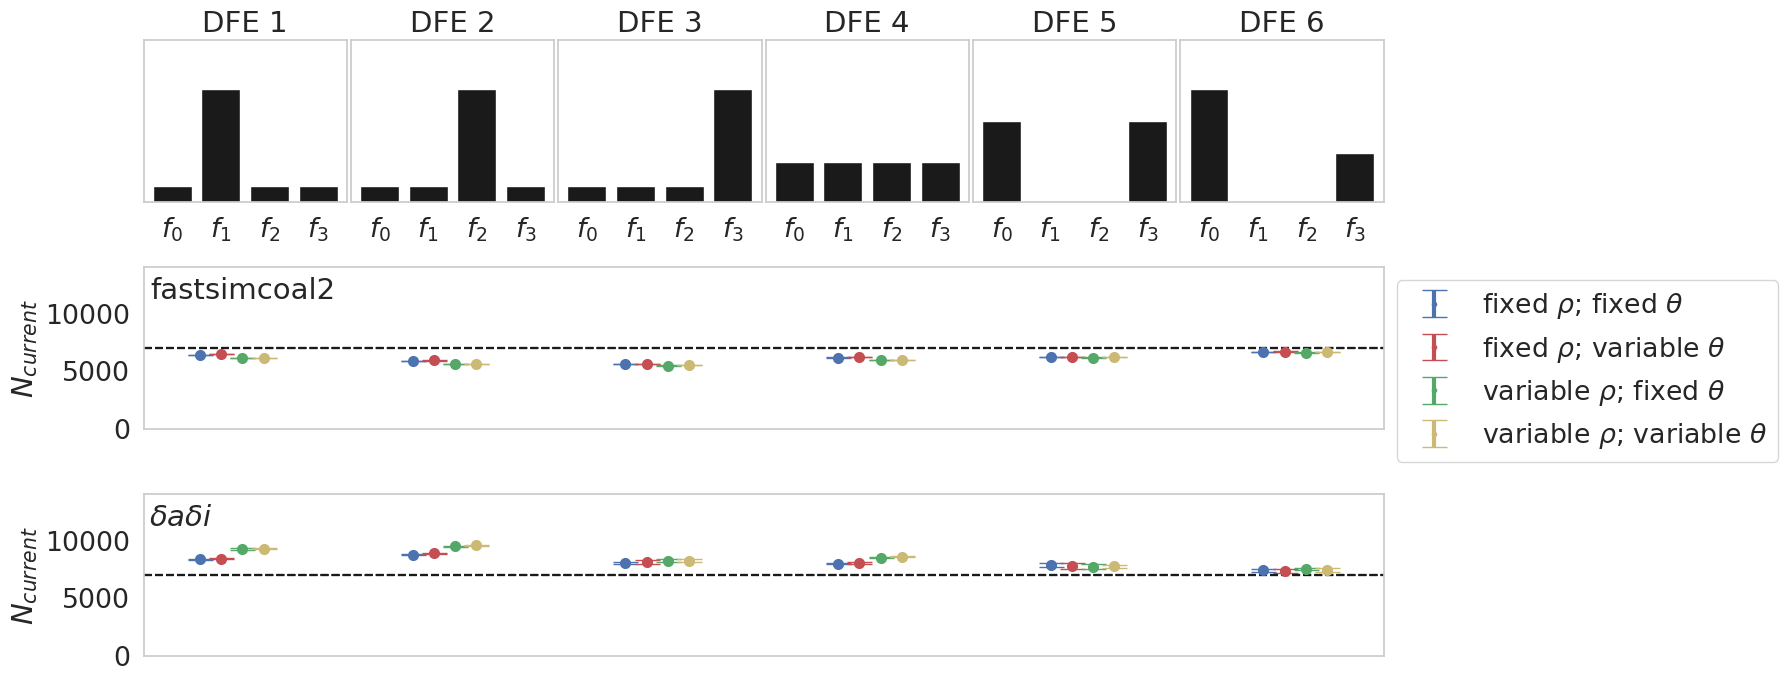

In [35]:
fig = plt.figure(figsize=(16, 8)) 
DFE = [[0.1,0.7,0.1,0.1],
      [0.1,0.1,0.7,0.1],
      [0.1,0.1,0.1,0.7],
      [0.25,0.25,0.25,0.25],
      [0.5,0,0,0.5],
      [0.7,0,0,0.3]]

sns.set(rc={'figure.figsize':(24,4),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.75)
x = [a for a in range(0,4)]
for i,j in enumerate(DFE):
    plt.subplot(3,6,i+1)
    plt.bar(x=x, height=j, color='k')
    plt.ylim([0,1])
#     if(i!=0):
#         plt.yticks([])
#     else:
#         plt.yticks([0, 0.5, 1])
#         plt.ylabel('Frequency', rotation=90)
    plt.yticks([])
#     plt.xticks([-1, 0, 1.25, 2.5], 
#                [r'$0 \leq 2N_es < 0.001$', r'$0.001 \leq 2N_es < 0.01$', r'$0.01 \leq 2N_es < 0.1$', r'$0.1 \leq 2N_es < 1$'], 
#            rotation=60)
    plt.xticks([0,1,2,3], [r'$f_0$', r'$f_1$', r'$f_2$', r'$f_3$'])
    plt.title('DFE ' + str(i+1))

ylims = [0, 14000]

c = ['b','r','g', 'y']
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
y = []
df = pd.DataFrame()
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
mins = []
maxes = []
means = []
std = []
for r in rr:
    for m in mu:
        fsc_lst = []
        lst = []
        for i in range(1, 7):
            fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference/fsc/sfs_files/demog_DFE/stationary/masked/"+
                              "rr_" + r + '_mu_' + m + "_sim"+str(i)+".bestlhoods",
                             sep='\t', names=['Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
            fsc['Ncurr'] = fsc.Ncurr/2
            fsc = fsc[fsc.Ncurr>0]
            fsc_lst.append(list(fsc.Ncurr))
            lst.append(['DFE'+str(i), fsc.Ncurr.mean(), fsc.Ncurr.std()])


        x = np.arange(6)+1
        y = fsc_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        means.append(np.array([np.mean(x) for x in y]))
        std.append(np.array([np.std(x) for x in y]))

plt.subplot(3,1,2)
l = [0,0,1,1]
for i in range(0, len(means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), means[i], std[i], fmt='o'+c[i], lw=3, markersize=7)
    plt.errorbar(x+(i*0.1), means[i], [means[i] - mins[i], maxes[i] - means[i]],
              fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=7000, color='k', linestyle='--')
plt.ylim(ylims)
#plt.xlabel('DFE')
plt.xticks([])
plt.ylabel(r'$N_{current}$')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('fastsimcoal2', x=0.08, y=0.75)


mins = []
maxes = []
means = []
std = []
df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        lst = []
        for sim in range(1, 7):
            ddf = pd.DataFrame()
            for rep in range(1, 11):
                dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_DFE/masked/" + 
                                   "stationary/rr_" + r + "_mu_" + m +  "/127_sim" + 
                                   str(sim) + "_run"+str(rep)+".txt",
                                 sep='\t', names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
                dadi = dadi[dadi.LogL==dadi.LogL.min()]
                dadi['rep'] = rep
                ddf = pd.concat([ddf,dadi])
            ddf = ddf[(ddf.Nu_opt > 0.02) & (ddf.Nu_opt <2.75)]
            ddf['Ncurr'] = ddf['Nu_opt'] * 7000
            lst.append(ddf.Ncurr)
            #ddf['DFE'] = sim
            #res.append([sim, ddf.Nu_opt.mean(), ddf.Nu_opt.std()])
            #Nu.append(np.array(ddf.Nu_opt))
        mins.append(np.array([np.quantile(x, 0.25) for x in lst]))
        maxes.append(np.array([np.quantile(x, 0.75) for x in lst]))
        means.append(np.array([np.mean(x) for x in lst]))
        std.append(np.array([np.std(x) for x in lst]))

plt.subplot(3,1,3)
l = [0,0,1,1]
for i in range(0, len(means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), means[i], std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), means[i], [means[i] - mins[i], maxes[i] - means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label='rr = ' + r + ', mu = ' + m)

    plt.axhline(y=7000, color='k', linestyle='--')
plt.ylim(ylims)
#plt.xlabel('DFE')
plt.xticks([])
plt.ylabel(r'$N_{current}$')
#plt.yticks([])
plt.title(r'$\delta$$a$$\delta$$i$', x=0.03, y=0.75)

plt.subplots_adjust(wspace=0.02, hspace=0.4)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/fig2.tiff', format='tiff', dpi=300, bbox_inches='tight')

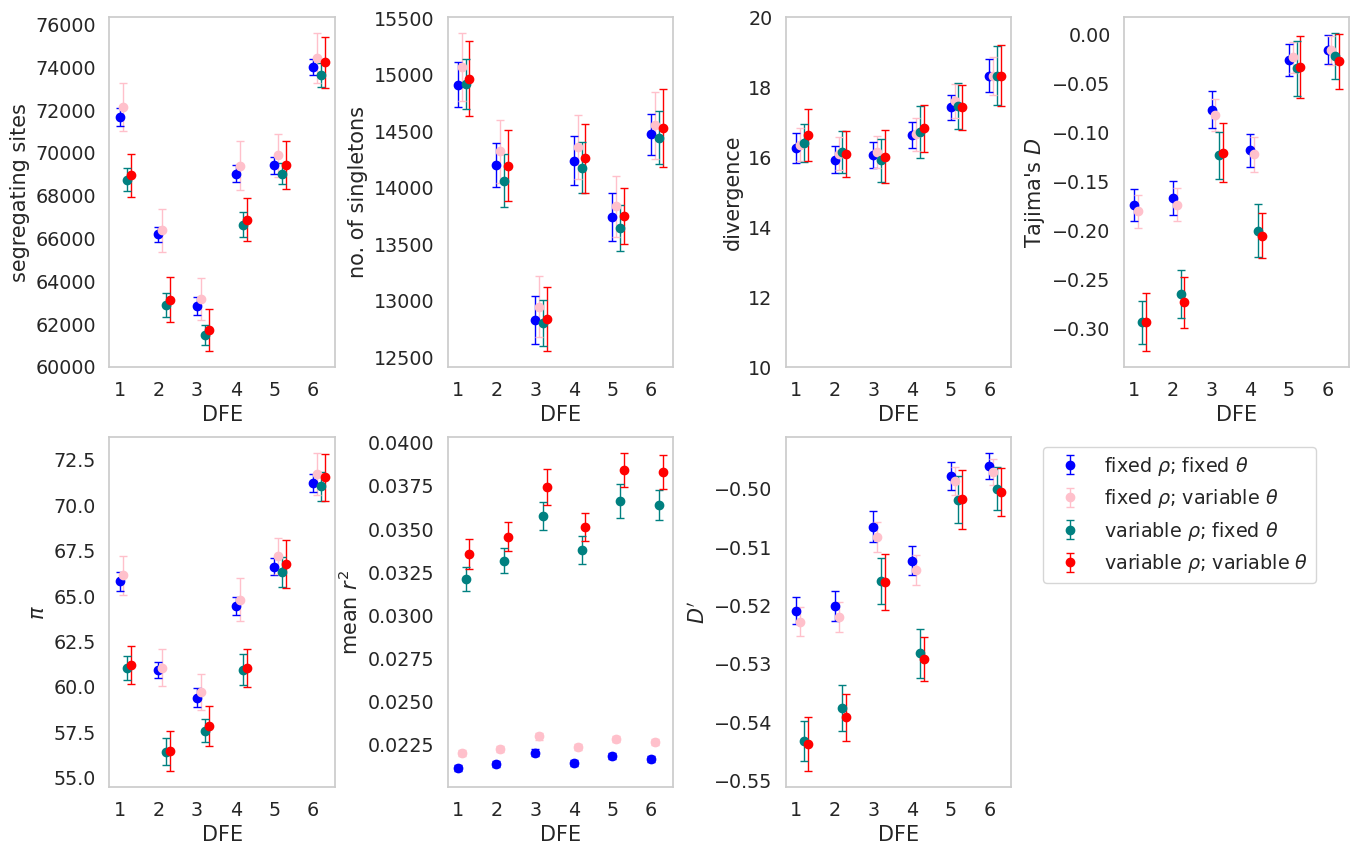

In [7]:
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
x = np.arange(6)+1
df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        lst = []
        sdf = pd.DataFrame()
        for sim in range(1, 7):
            stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_DFE/stationary/rr_" + 
                                r + "_mu_" + m + "_sim" + str(sim) + ".stats", sep='\t', header=0)
            stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
            lst = []
            for i in stats.columns:
                lst.append(stats[i].mean())
                lst.append(stats[i].std())

            tdf = pd.DataFrame(lst).T
            tdf['DFE'] = sim
            sdf = pd.concat([sdf, tdf])
        sdf['rr'] = r
        sdf['mu'] = m
        df = pd.concat([df, sdf])


ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    l = [0,0,1,1]
    for i in range(0, 4):
        r = rr[l[i]]
        m = mu[i%2]
        pdf = df[(df.rr==r) & (df.mu==m)]
        plt.errorbar(x+(i*0.1), pdf[j*2], pdf[(j*2)+1], fmt='o', color=c[i], lw=1, capsize=3, zorder=15, 
                    label=labs[i])
    if(j==6):
        plt.legend(bbox_to_anchor=(1.1, 1))
    if(k=='divergence'):
        plt.ylim([10, 20])
    #plt.ylim([0.5, 2.5])
    #plt.yticks([])
    plt.xticks([1,2,3,4,5,6])
    plt.xlabel('DFE')
    plt.ylabel(k)

plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS10.tiff', format='tiff', dpi=300, bbox_inches='tight')

<h2>Demog DFE - Expansion</h2>

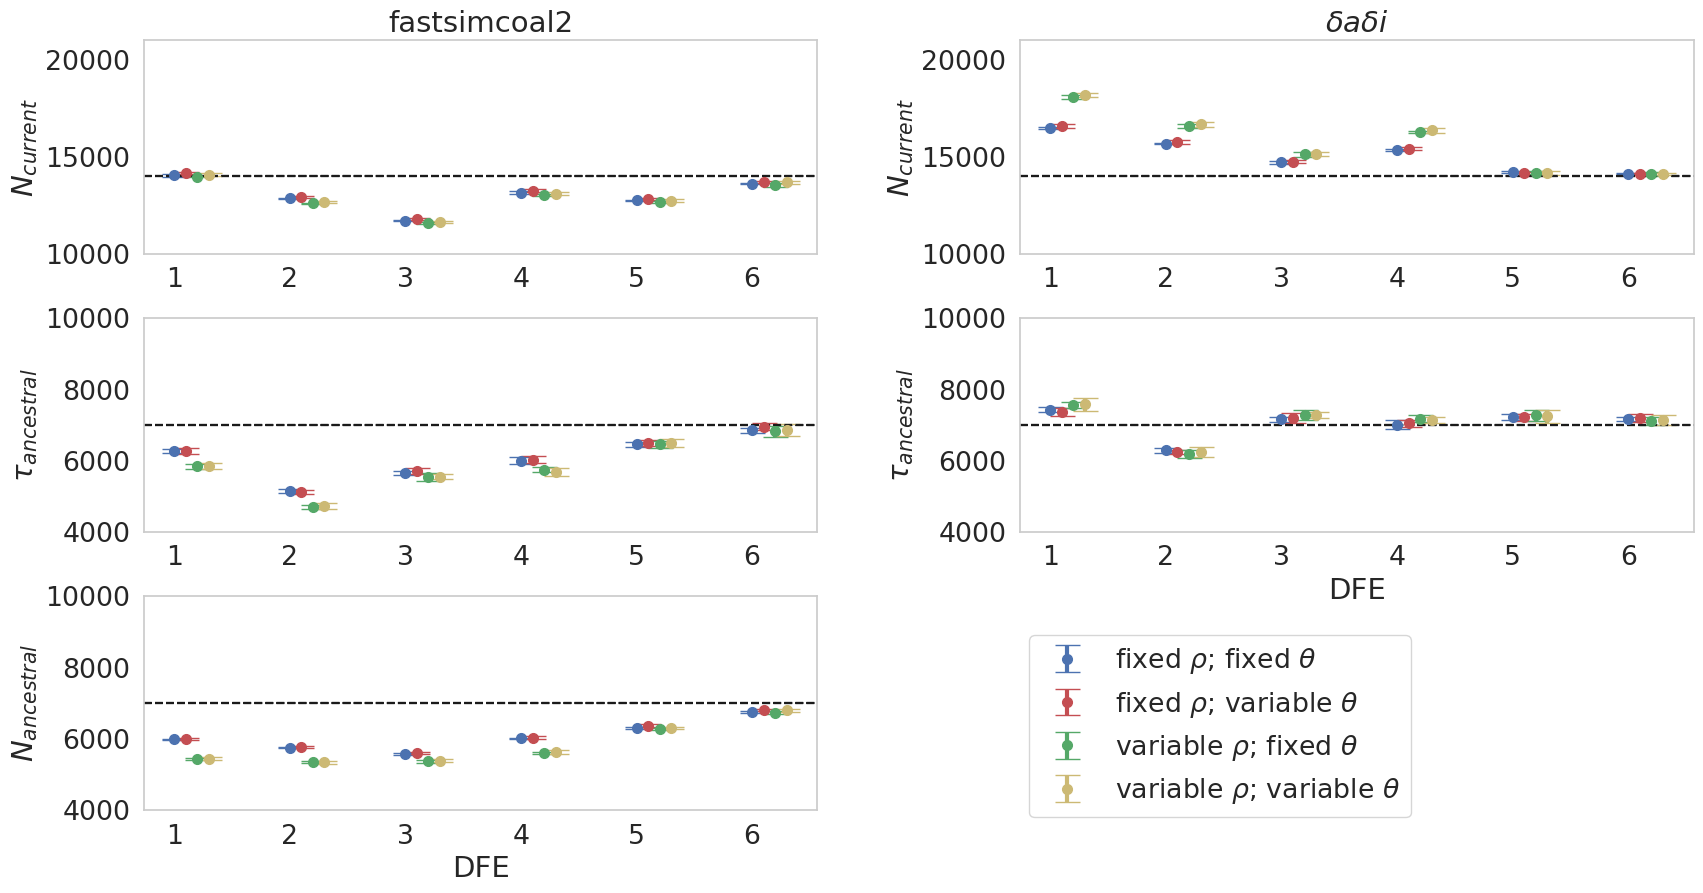

In [45]:
true_Nanc = 7000
true_Ncurr = 14000
true_tanc = 7000
Nanc_lims = [4000, 10000]
Ncurr_lims = [10000, 21000]
tanc_lims = [4000, 10000]

sns.set(rc={'figure.figsize':(20,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.75)
c = ['b','r','g', 'y']
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
y = []
df = pd.DataFrame()
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
Ncurr_mins = []
Ncurr_maxes = []
Ncurr_means = []
Ncurr_std = []
Nanc_mins = []
Nanc_maxes = []
Nanc_means = []
Nanc_std = []
tanc_mins = []
tanc_maxes = []
tanc_means = []
tanc_std = []

for r in rr:
    for m in mu:
        Ncurr_lst = []
        Nanc_lst = []
        tanc_lst = []
        for i in range(1, 7):
            try:
                fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference/fsc/sfs_files/demog_DFE/expansion/masked/"+
                                  "rr_" + r + '_mu_' + m + "_sim"+str(i)+".bestlhoods",
                                 sep='\t', names=['Ncurr', 'Nanc', 'tanc', 'Nanc/Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
                fsc['Ncurr'] = fsc.Ncurr/2
                fsc['Nanc'] = fsc.Nanc/2
                fsc = fsc[fsc.Ncurr>0]
                Ncurr_lst.append(list(fsc.Ncurr))
                Nanc_lst.append(list(fsc.Nanc))
                tanc_lst.append(list(fsc.tanc))
            except Exception:
                pass

        x = np.arange(6)+1
        y = Ncurr_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        Ncurr_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        Ncurr_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        Ncurr_means.append(np.array([np.mean(x) for x in y]))
        Ncurr_std.append(np.array([np.std(x) for x in y]))
        
        y = Nanc_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        Nanc_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        Nanc_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        Nanc_means.append(np.array([np.mean(x) for x in y]))
        Nanc_std.append(np.array([np.std(x) for x in y]))
        
        y = tanc_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        tanc_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        tanc_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        tanc_means.append(np.array([np.mean(x) for x in y]))
        tanc_std.append(np.array([np.std(x) for x in y]))

plt.subplot(3,2,1)
l = [0,0,1,1]
for i in range(0, len(Ncurr_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Ncurr_means[i], Ncurr_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), Ncurr_means[i], [Ncurr_means[i] - Ncurr_mins[i], Ncurr_maxes[i] - Ncurr_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_Ncurr, color='k', linestyle='--')
plt.ylim(Ncurr_lims)
plt.ylabel(r'$N_{current}$')
plt.title(r'fastsimcoal2')
#Plot FSC results
plt.subplot(3,2,3)
l = [0,0,1,1]
for i in range(0, len(Nanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), tanc_means[i], tanc_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), tanc_means[i], [tanc_means[i] - tanc_mins[i], tanc_maxes[i] - tanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_tanc, color='k', linestyle='--')
plt.ylim(tanc_lims)
plt.ylabel(r'$\tau_{ancestral}$')

plt.subplot(3,2,5)
l = [0,0,1,1]
for i in range(0, len(tanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Nanc_means[i], Nanc_std[i], fmt='o'+c[i], lw=3, capsize=9,  markersize=7)
#     plt.errorbar(x+(i*0.1), Nanc_means[i], [Nanc_means[i] - Nanc_mins[i], Nanc_maxes[i] - Nanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_Nanc, color='k', linestyle='--')
plt.ylim(Nanc_lims)
plt.xlabel('DFE')
plt.ylabel(r'$N_{ancestral}$')




#Plot dadi results
Ncurr_mins = []
Ncurr_maxes = []
Ncurr_means = []
Ncurr_std = []
tanc_mins = []
tanc_maxes = []
tanc_means = []
tanc_std = []

df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        Ncurr_lst = []
        tanc_lst = []
        for sim in range(1, 7):
            ddf = pd.DataFrame()
            for rep in range(1, 11):
                try:
                    dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_DFE/masked/" + 
                                       "expansion/rr_" + r + "_mu_" + m +  "/127_sim" + 
                                       str(sim) + "_run"+str(rep)+".txt",
                                     sep='\t', names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
                    dadi = dadi[dadi.LogL==dadi.LogL.min()]
                    dadi['rep'] = rep
                    ddf = pd.concat([ddf,dadi])
                except Exception:
                    pass
                    
            ddf = ddf[(ddf.Nu_opt > 0.02) & (ddf.Nu_opt <2.75)]
            ddf['Ncurr'] = ddf['Nu_opt'] * true_Nanc
            ddf['tanc'] = ddf['t_opt'] * true_Nanc * 2
            Ncurr_lst.append(ddf.Ncurr)
            tanc_lst.append(ddf.tanc)

        Ncurr_mins.append(np.array([np.quantile(x, 0.25) for x in Ncurr_lst]))
        Ncurr_maxes.append(np.array([np.quantile(x, 0.75) for x in Ncurr_lst]))
        Ncurr_means.append(np.array([np.mean(x) for x in Ncurr_lst]))
        Ncurr_std.append(np.array([np.std(x) for x in Ncurr_lst]))
        
        tanc_mins.append(np.array([np.quantile(x, 0.25) for x in tanc_lst]))
        tanc_maxes.append(np.array([np.quantile(x, 0.75) for x in tanc_lst]))
        tanc_means.append(np.array([np.mean(x) for x in tanc_lst]))
        tanc_std.append(np.array([np.std(x) for x in tanc_lst]))

plt.subplot(3,2,2)
l = [0,0,1,1]
for i in range(0, len(Ncurr_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Ncurr_means[i], Ncurr_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), Ncurr_means[i], [Ncurr_means[i] - Ncurr_mins[i], Ncurr_maxes[i] - Ncurr_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label='rr = ' + r + ', mu = ' + m)

    plt.axhline(y=true_Ncurr, color='k', linestyle='--')
plt.ylim(Ncurr_lims)
plt.ylabel(r'$N_{current}$')
plt.title(r'$\delta$$a$$\delta$$i$')

plt.subplot(3,2,4)
l = [0,0,1,1]
for i in range(0, len(tanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1),tanc_means[i], tanc_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7,
                label=labs[i])
#     plt.errorbar(x+(i*0.1), tanc_means[i], [tanc_means[i] - tanc_mins[i], tanc_maxes[i] - tanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label='rr = ' + r + ', mu = ' + m)

    plt.axhline(y=true_tanc, color='k', linestyle='--')
plt.ylim(tanc_lims)
plt.xlabel('DFE')
plt.ylabel(r'$\tau_{ancestral}$')

plt.legend(bbox_to_anchor=(0.6, -0.42))

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# plt.savefig('/home/vivak/rr_mu_demog_inference/plots/fig2.tiff', format='tiff', dpi=300)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/fig16.tiff', format='tiff', dpi=300, bbox_inches='tight')

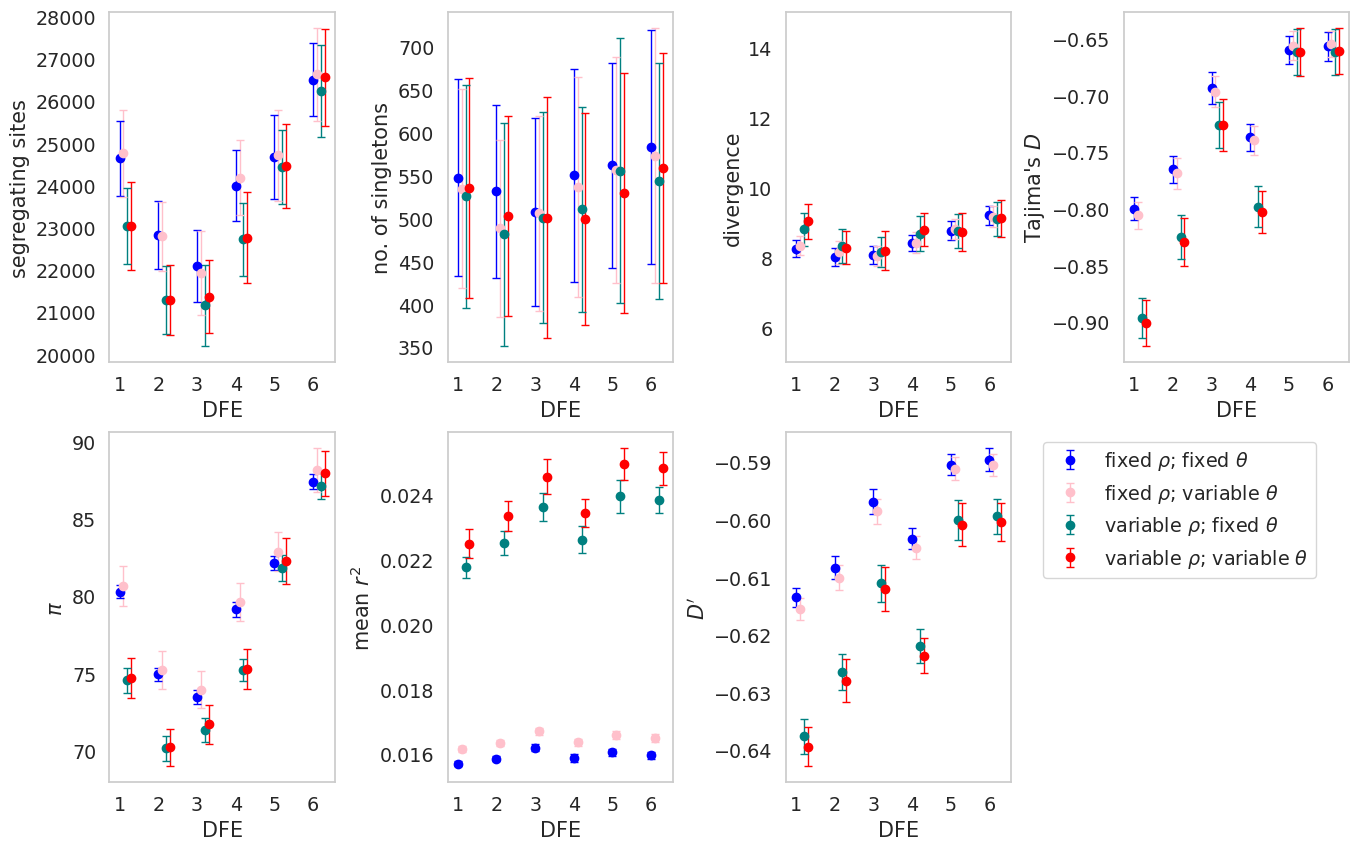

In [17]:
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
x = np.arange(6)+1
df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        lst = []
        sdf = pd.DataFrame()
        for sim in range(1, 7):
            stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_DFE/expansion/rr_" + 
                                r + "_mu_" + m + "_sim" + str(sim) + ".stats", sep='\t', header=0)
            stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
            lst = []
            for i in stats.columns:
                lst.append(stats[i].mean())
                lst.append(stats[i].std())

            tdf = pd.DataFrame(lst).T
            tdf['DFE'] = sim
            sdf = pd.concat([sdf, tdf])
        sdf['rr'] = r
        sdf['mu'] = m
        df = pd.concat([df, sdf])


ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    l = [0,0,1,1]
    for i in range(0, 4):
        r = rr[l[i]]
        m = mu[i%2]
        pdf = df[(df.rr==r) & (df.mu==m)]
        plt.errorbar(x+(i*0.1), pdf[j*2], pdf[(j*2)+1], fmt='o', color=c[i], lw=1, capsize=3, zorder=15, 
                    label=labs[i])
    if(j==6):
        plt.legend(bbox_to_anchor=(1.1, 1))
    if(k=='divergence'):
        plt.ylim([5, 15])
    #plt.ylim([0.5, 2.5])
    #plt.yticks([])
    plt.xticks([1,2,3,4,5,6])
    plt.xlabel('DFE')
    plt.ylabel(k)

plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS19.tiff', format='tiff', dpi=300, bbox_inches='tight')

<h2>Demog DFE - Contraction</h2>

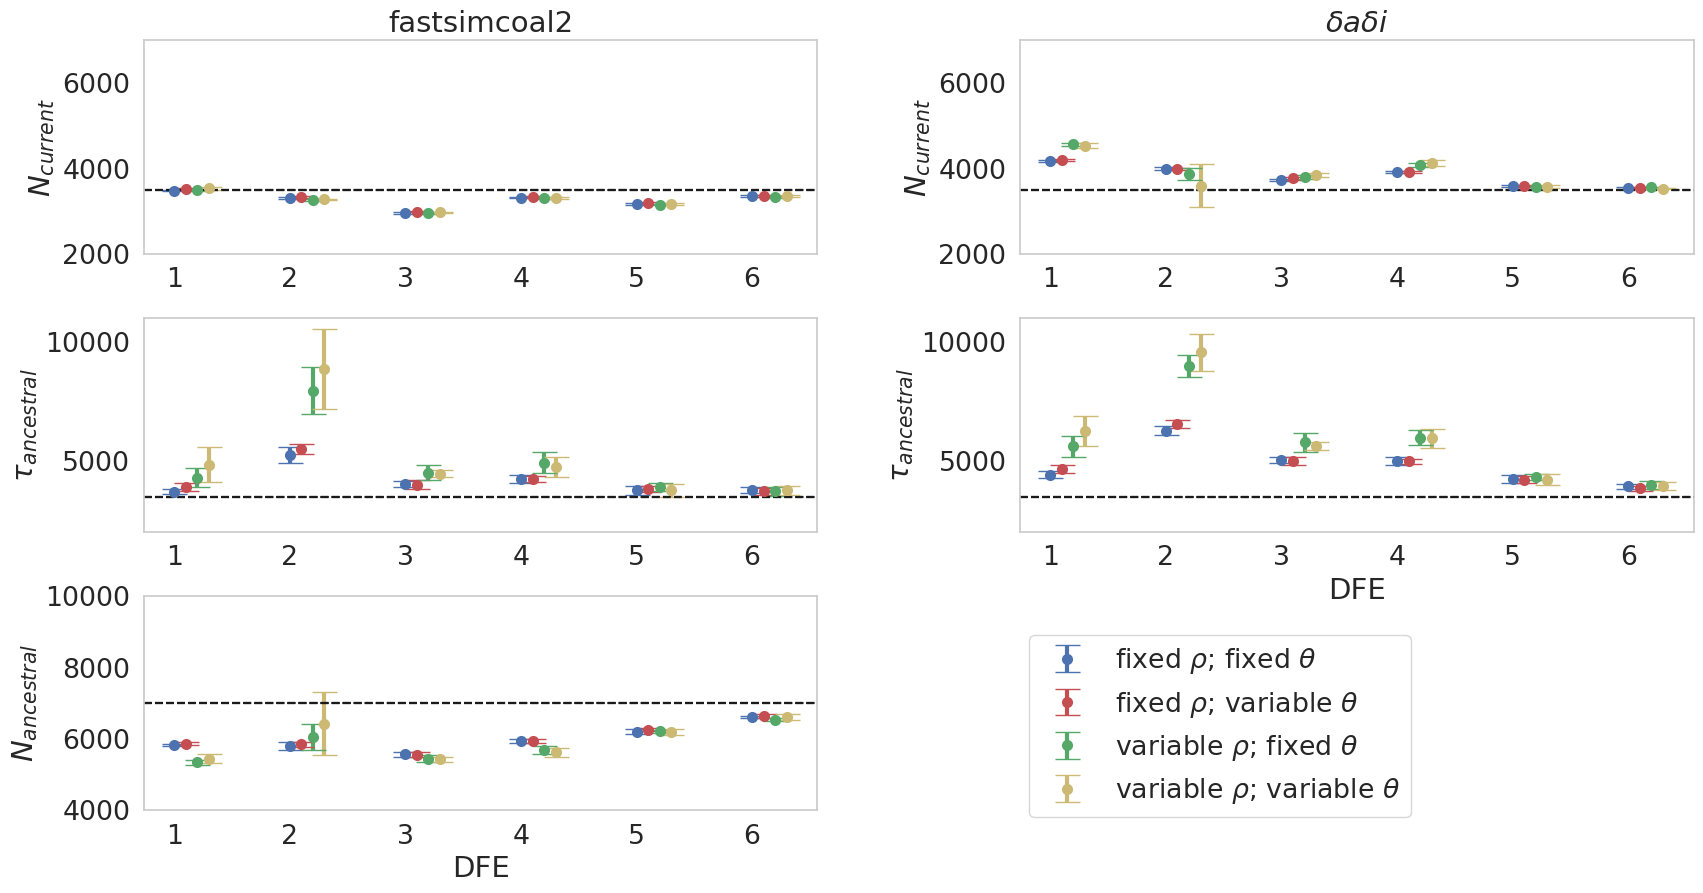

In [15]:
true_Nanc = 7000
true_Ncurr = 3500
true_tanc = 3500
Nanc_lims = [4000, 10000]
Ncurr_lims = [2000, 7000]
tanc_lims = [2000, 11000]


sns.set(rc={'figure.figsize':(20,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.75)
c = ['b','r','g', 'y']
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
y = []
df = pd.DataFrame()
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
Ncurr_mins = []
Ncurr_maxes = []
Ncurr_means = []
Ncurr_std = []
Nanc_mins = []
Nanc_maxes = []
Nanc_means = []
Nanc_std = []
tanc_mins = []
tanc_maxes = []
tanc_means = []
tanc_std = []

for r in rr:
    for m in mu:
        Ncurr_lst = []
        Nanc_lst = []
        tanc_lst = []
        for i in range(1, 7):
            fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference/fsc/sfs_files/demog_DFE/contraction/"+
                              "rr_" + r + '_mu_' + m + "_sim"+str(i)+".bestlhoods",
                             sep='\t', names=['Ncurr', 'Nanc', 'tanc', 'Nanc/Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
            fsc['Ncurr'] = fsc.Ncurr/2
            fsc['Nanc'] = fsc.Nanc/2
            fsc = fsc[fsc.Ncurr>0]
            Ncurr_lst.append(list(fsc.Ncurr))
            Nanc_lst.append(list(fsc.Nanc))
            tanc_lst.append(list(fsc.tanc))

        x = np.arange(6)+1
        y = Ncurr_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        Ncurr_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        Ncurr_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        Ncurr_means.append(np.array([np.mean(x) for x in y]))
        Ncurr_std.append(np.array([np.std(x) for x in y]))
        
        y = Nanc_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        Nanc_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        Nanc_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        Nanc_means.append(np.array([np.mean(x) for x in y]))
        Nanc_std.append(np.array([np.std(x) for x in y]))
        
        y = tanc_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        tanc_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        tanc_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        tanc_means.append(np.array([np.mean(x) for x in y]))
        tanc_std.append(np.array([np.std(x) for x in y]))

plt.subplot(3,2,1)
l = [0,0,1,1]
for i in range(0, len(Ncurr_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Ncurr_means[i], Ncurr_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), Ncurr_means[i], [Ncurr_means[i] - Ncurr_mins[i], Ncurr_maxes[i] - Ncurr_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_Ncurr, color='k', linestyle='--')
plt.ylim(Ncurr_lims)
plt.ylabel(r'$N_{current}$')
plt.title(r'fastsimcoal2')
#Plot FSC results
plt.subplot(3,2,3)
l = [0,0,1,1]
for i in range(0, len(Nanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), tanc_means[i], tanc_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), tanc_means[i], [tanc_means[i] - tanc_mins[i], tanc_maxes[i] - tanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_tanc, color='k', linestyle='--')
plt.ylim(tanc_lims)
plt.ylabel(r'$\tau_{ancestral}$')

plt.subplot(3,2,5)
l = [0,0,1,1]
for i in range(0, len(tanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Nanc_means[i], Nanc_std[i], fmt='o'+c[i], lw=3, capsize=9,  markersize=7)
#     plt.errorbar(x+(i*0.1), Nanc_means[i], [Nanc_means[i] - Nanc_mins[i], Nanc_maxes[i] - Nanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_Nanc, color='k', linestyle='--')
plt.ylim(Nanc_lims)
plt.xlabel('DFE')
plt.ylabel(r'$N_{ancestral}$')




#Plot dadi results
Ncurr_mins = []
Ncurr_maxes = []
Ncurr_means = []
Ncurr_std = []
tanc_mins = []
tanc_maxes = []
tanc_means = []
tanc_std = []

df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        Ncurr_lst = []
        tanc_lst = []
        for sim in range(1, 7):
            ddf = pd.DataFrame()
            for rep in range(1, 11):
                dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_DFE/" + 
                                   "contraction/rr_" + r + "_mu_" + m +  "/127_sim" + 
                                   str(sim) + "_run"+str(rep)+".txt",
                                 sep='\t', names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
                dadi = dadi[dadi.LogL==dadi.LogL.min()]
                dadi['rep'] = rep
                ddf = pd.concat([ddf,dadi])
            ddf = ddf[(ddf.Nu_opt > 0.02) & (ddf.Nu_opt <2.75)]
            ddf['Ncurr'] = ddf['Nu_opt'] * true_Nanc
            ddf['tanc'] = ddf['t_opt'] * true_Nanc * 2
            Ncurr_lst.append(ddf.Ncurr)
            tanc_lst.append(ddf.tanc)

        Ncurr_mins.append(np.array([np.quantile(x, 0.25) for x in Ncurr_lst]))
        Ncurr_maxes.append(np.array([np.quantile(x, 0.75) for x in Ncurr_lst]))
        Ncurr_means.append(np.array([np.mean(x) for x in Ncurr_lst]))
        Ncurr_std.append(np.array([np.std(x) for x in Ncurr_lst]))
        
        tanc_mins.append(np.array([np.quantile(x, 0.25) for x in tanc_lst]))
        tanc_maxes.append(np.array([np.quantile(x, 0.75) for x in tanc_lst]))
        tanc_means.append(np.array([np.mean(x) for x in tanc_lst]))
        tanc_std.append(np.array([np.std(x) for x in tanc_lst]))

plt.subplot(3,2,2)
l = [0,0,1,1]
for i in range(0, len(Ncurr_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Ncurr_means[i], Ncurr_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), Ncurr_means[i], [Ncurr_means[i] - Ncurr_mins[i], Ncurr_maxes[i] - Ncurr_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label='rr = ' + r + ', mu = ' + m)

    plt.axhline(y=true_Ncurr, color='k', linestyle='--')
plt.ylim(Ncurr_lims)
plt.ylabel(r'$N_{current}$')
plt.title(r'$\delta$$a$$\delta$$i$')

plt.subplot(3,2,4)
l = [0,0,1,1]
for i in range(0, len(tanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1),tanc_means[i], tanc_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7,
                label=labs[i])
#     plt.errorbar(x+(i*0.1), tanc_means[i], [tanc_means[i] - tanc_mins[i], tanc_maxes[i] - tanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label='rr = ' + r + ', mu = ' + m)

    plt.axhline(y=true_tanc, color='k', linestyle='--')
plt.ylim(tanc_lims)
plt.xlabel('DFE')
plt.ylabel(r'$\tau_{ancestral}$')

plt.legend(bbox_to_anchor=(0.6, -0.42))

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS17.tiff', format='tiff', dpi=300, bbox_inches='tight')

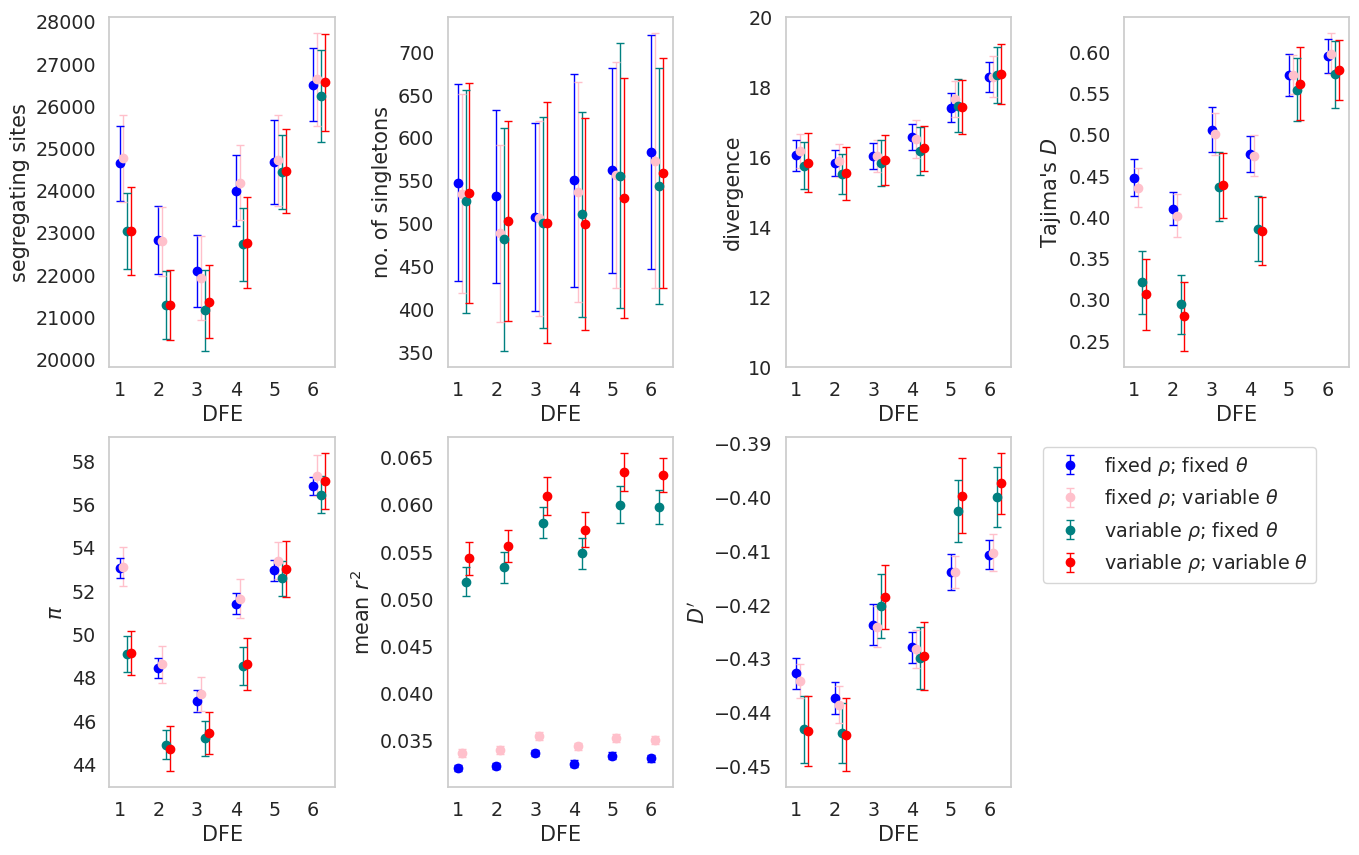

In [18]:
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
x = np.arange(6)+1
df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        lst = []
        sdf = pd.DataFrame()
        for sim in range(1, 7):
            stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_DFE/contraction/rr_" + 
                                r + "_mu_" + m + "_sim" + str(sim) + ".stats", sep='\t', header=0)
            stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
            lst = []
            for i in stats.columns:
                lst.append(stats[i].mean())
                lst.append(stats[i].std())

            tdf = pd.DataFrame(lst).T
            tdf['DFE'] = sim
            sdf = pd.concat([sdf, tdf])
        sdf['rr'] = r
        sdf['mu'] = m
        df = pd.concat([df, sdf])


ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    l = [0,0,1,1]
    for i in range(0, 4):
        r = rr[l[i]]
        m = mu[i%2]
        pdf = df[(df.rr==r) & (df.mu==m)]
        plt.errorbar(x+(i*0.1), pdf[j*2], pdf[(j*2)+1], fmt='o', color=c[i], lw=1, capsize=3, zorder=15, 
                    label=labs[i])
    if(j==6):
        plt.legend(bbox_to_anchor=(1.1, 1))
    if(k=='divergence'):
        plt.ylim([10, 20])
    #plt.ylim([0.5, 2.5])
    #plt.yticks([])
    plt.xticks([1,2,3,4,5,6])
    plt.xlabel('DFE')
    plt.ylabel(k)

plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS20.tiff', format='tiff', dpi=300, bbox_inches='tight')

<h2>Demog DFE - 99% contraction</h2>

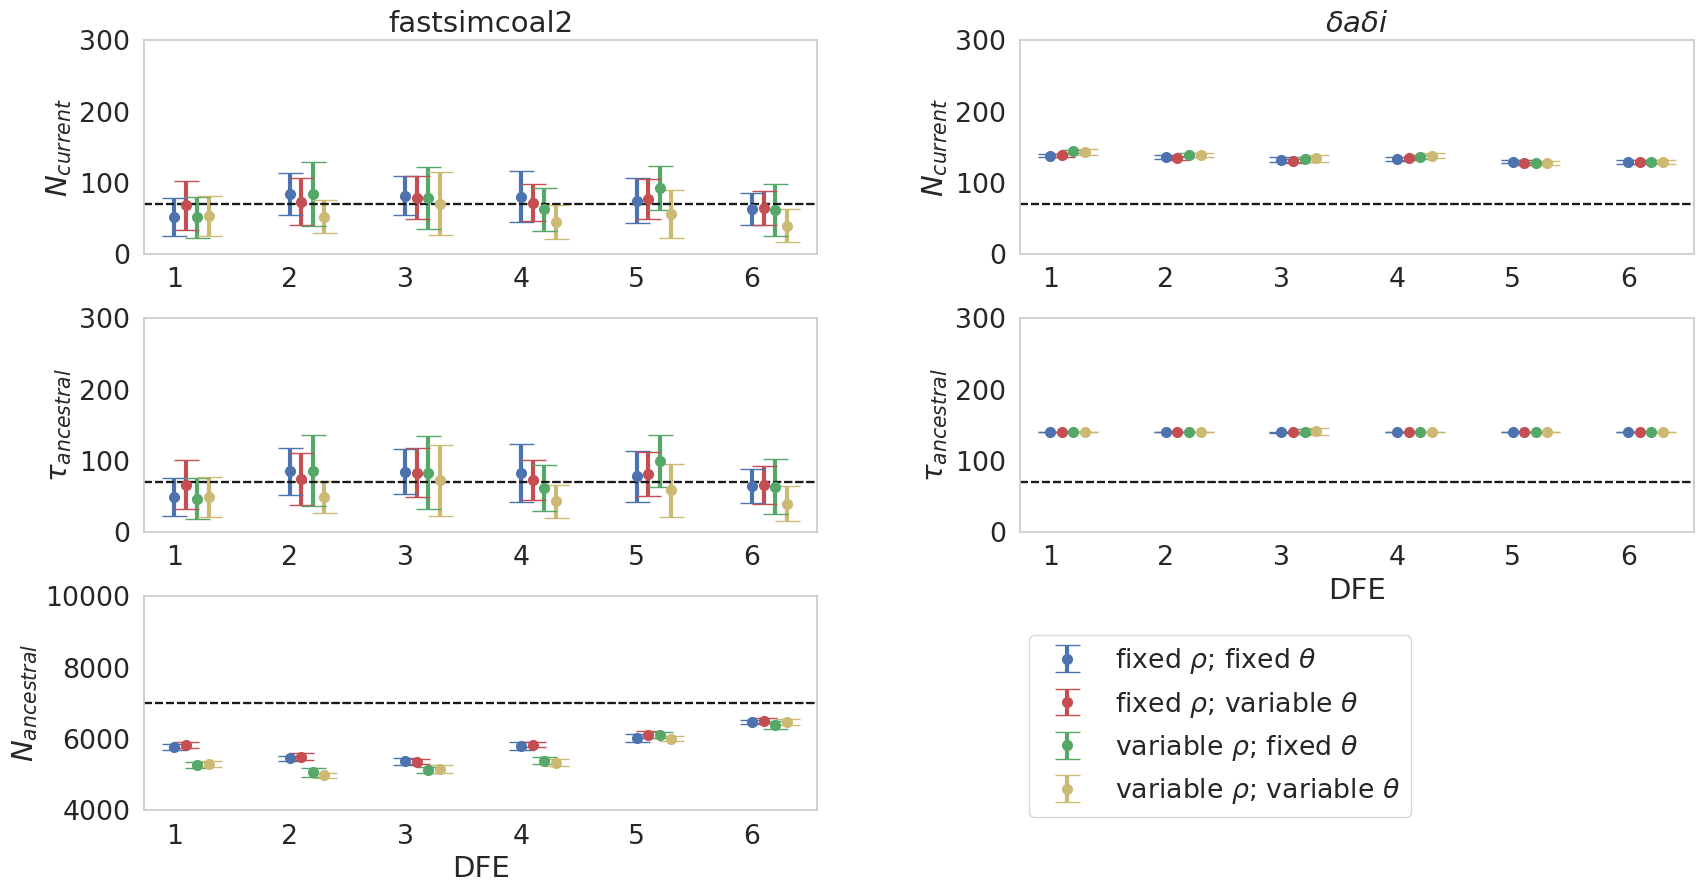

In [16]:
true_Nanc = 7000
true_Ncurr = 70
true_tanc = 70
Nanc_lims = [4000, 10000]
Ncurr_lims = [0, 300]
tanc_lims = [0, 300]

sns.set(rc={'figure.figsize':(20,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.75)
c = ['b','r','g', 'y']
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
y = []
df = pd.DataFrame()
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
Ncurr_mins = []
Ncurr_maxes = []
Ncurr_means = []
Ncurr_std = []
Nanc_mins = []
Nanc_maxes = []
Nanc_means = []
Nanc_std = []
tanc_mins = []
tanc_maxes = []
tanc_means = []
tanc_std = []

for r in rr:
    for m in mu:
        Ncurr_lst = []
        Nanc_lst = []
        tanc_lst = []
        for i in range(1, 7):
            fsc = pd.read_csv("/home/vivak/rr_mu_demog_inference/fsc/sfs_files/demog_DFE/cc/"+
                              "rr_" + r + '_mu_' + m + "_sim"+str(i)+".bestlhoods",
                             sep='\t', names=['Ncurr', 'Nanc', 'tanc', 'Nanc/Ncurr', 'maxObsLhood', 'maxExpLhood', 'LhoodDiff'])
            fsc['Ncurr'] = fsc.Ncurr/2
            fsc['Nanc'] = fsc.Nanc/2
            fsc = fsc[fsc.Ncurr>0]
            Ncurr_lst.append(list(fsc.Ncurr))
            Nanc_lst.append(list(fsc.Nanc))
            tanc_lst.append(list(fsc.tanc))

        x = np.arange(6)+1
        y = Ncurr_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        Ncurr_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        Ncurr_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        Ncurr_means.append(np.array([np.mean(x) for x in y]))
        Ncurr_std.append(np.array([np.std(x) for x in y]))
        
        y = Nanc_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        Nanc_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        Nanc_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        Nanc_means.append(np.array([np.mean(x) for x in y]))
        Nanc_std.append(np.array([np.std(x) for x in y]))
        
        y = tanc_lst
        df2 = pd.DataFrame(y).T.dropna()
        df2.columns = np.arange(6)+1
        df2['rr'] = r
        df2['mu'] = m
        df = pd.concat([df, df2])

        tanc_mins.append(np.array([np.quantile(x, 0.25) for x in y]))
        tanc_maxes.append(np.array([np.quantile(x, 0.75) for x in y]))
        tanc_means.append(np.array([np.mean(x) for x in y]))
        tanc_std.append(np.array([np.std(x) for x in y]))

plt.subplot(3,2,1)
l = [0,0,1,1]
for i in range(0, len(Ncurr_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Ncurr_means[i], Ncurr_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), Ncurr_means[i], [Ncurr_means[i] - Ncurr_mins[i], Ncurr_maxes[i] - Ncurr_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_Ncurr, color='k', linestyle='--')
plt.ylim(Ncurr_lims)
plt.ylabel(r'$N_{current}$')
plt.title(r'fastsimcoal2')
#Plot FSC results
plt.subplot(3,2,3)
l = [0,0,1,1]
for i in range(0, len(Nanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), tanc_means[i], tanc_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), tanc_means[i], [tanc_means[i] - tanc_mins[i], tanc_maxes[i] - tanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_tanc, color='k', linestyle='--')
plt.ylim(tanc_lims)
plt.ylabel(r'$\tau_{ancestral}$')

plt.subplot(3,2,5)
l = [0,0,1,1]
for i in range(0, len(tanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Nanc_means[i], Nanc_std[i], fmt='o'+c[i], lw=3, capsize=9,  markersize=7)
#     plt.errorbar(x+(i*0.1), Nanc_means[i], [Nanc_means[i] - Nanc_mins[i], Nanc_maxes[i] - Nanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label=labs[i])

    plt.axhline(y=true_Nanc, color='k', linestyle='--')
plt.ylim(Nanc_lims)
plt.xlabel('DFE')
plt.ylabel(r'$N_{ancestral}$')




#Plot dadi results
Ncurr_mins = []
Ncurr_maxes = []
Ncurr_means = []
Ncurr_std = []
tanc_mins = []
tanc_maxes = []
tanc_means = []
tanc_std = []

df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        Ncurr_lst = []
        tanc_lst = []
        for sim in range(1, 7):
            ddf = pd.DataFrame()
            for rep in range(1, 11):
                dadi = pd.read_csv("/home/vivak/rr_mu_demog_inference/dadi/sfs_files/demog_DFE/" + 
                                   "cc/rr_" + r + "_mu_" + m +  "/127_sim" + 
                                   str(sim) + "_run"+str(rep)+".txt",
                                 sep='\t', names=['Nu_init', 't_init', 'Nu_opt', 't_opt', 'LogL', 'fs', 'func_ex',' pts_l'])
                dadi = dadi[dadi.LogL==dadi.LogL.min()]
                dadi['rep'] = rep
                ddf = pd.concat([ddf,dadi])
            ddf = ddf[(ddf.Nu_opt <2.75)]
            ddf['Ncurr'] = ddf['Nu_opt'] * true_Nanc
            ddf['tanc'] = ddf['t_opt'] * true_Nanc * 2
            Ncurr_lst.append(ddf.Ncurr)
            tanc_lst.append(ddf.tanc)

        Ncurr_mins.append(np.array([np.quantile(x, 0.25) for x in Ncurr_lst]))
        Ncurr_maxes.append(np.array([np.quantile(x, 0.75) for x in Ncurr_lst]))
        Ncurr_means.append(np.array([np.mean(x) for x in Ncurr_lst]))
        Ncurr_std.append(np.array([np.std(x) for x in Ncurr_lst]))
        
        tanc_mins.append(np.array([np.quantile(x, 0.25) for x in tanc_lst]))
        tanc_maxes.append(np.array([np.quantile(x, 0.75) for x in tanc_lst]))
        tanc_means.append(np.array([np.mean(x) for x in tanc_lst]))
        tanc_std.append(np.array([np.std(x) for x in tanc_lst]))

plt.subplot(3,2,2)
l = [0,0,1,1]
for i in range(0, len(Ncurr_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1), Ncurr_means[i], Ncurr_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7)
#     plt.errorbar(x+(i*0.1), Ncurr_means[i], [Ncurr_means[i] - Ncurr_mins[i], Ncurr_maxes[i] - Ncurr_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label='rr = ' + r + ', mu = ' + m)

    plt.axhline(y=true_Ncurr, color='k', linestyle='--')
plt.ylim(Ncurr_lims)
plt.ylabel(r'$N_{current}$')
plt.title(r'$\delta$$a$$\delta$$i$')

plt.subplot(3,2,4)
l = [0,0,1,1]
for i in range(0, len(tanc_means)):
    r = rr[l[i]]
    m = mu[i%2]
    plt.errorbar(x+(i*0.1),tanc_means[i], tanc_std[i], fmt='o'+c[i], lw=3, capsize=9, markersize=7,
                label=labs[i])
#     plt.errorbar(x+(i*0.1), tanc_means[i], [tanc_means[i] - tanc_mins[i], tanc_maxes[i] - tanc_means[i]],
#               fmt='.'+c[i], ecolor=c[i], lw=3, capsize=9, label='rr = ' + r + ', mu = ' + m)

    plt.axhline(y=true_tanc, color='k', linestyle='--')
plt.ylim(tanc_lims)
plt.xlabel('DFE')
plt.ylabel(r'$\tau_{ancestral}$')

plt.legend(bbox_to_anchor=(0.6, -0.42))

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS18.tiff', format='tiff', dpi=300, bbox_inches='tight')

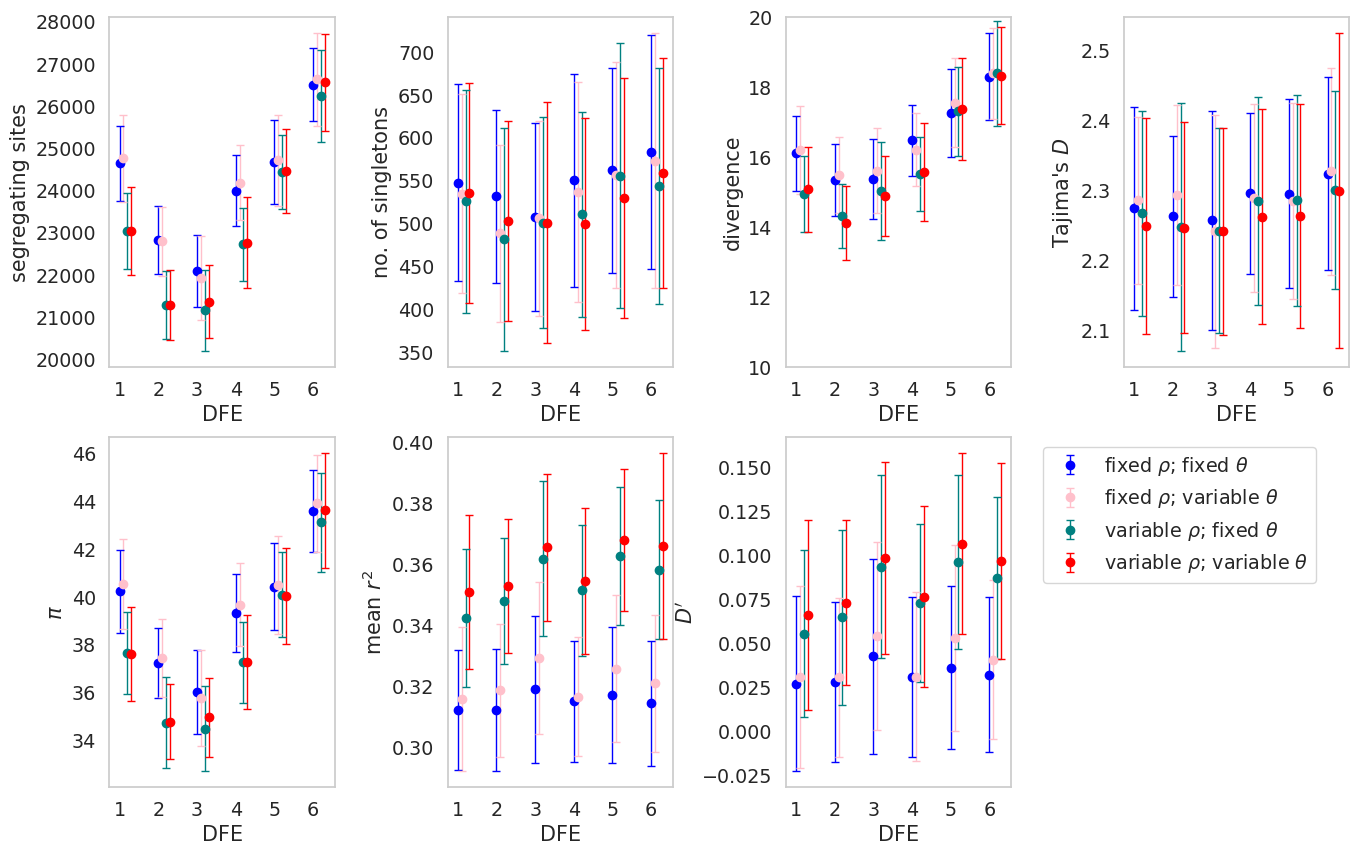

In [19]:
labs = [r'fixed ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'fixed ' + u'$\u03C1$;' + ' variable ' + r'$\theta$',
        r'variable ' + u'$\u03C1$;' + ' fixed ' + r'$\theta$', r'variable ' + u'$\u03C1$;' + ' variable ' + r'$\theta$']
rr = ['fixed', 'variable']
mu = ['fixed', 'variable']
c = ['blue','pink','teal', 'red']
x = np.arange(6)+1
df = pd.DataFrame()
for r in rr:
    for m in mu:

        Nu = []
        lst = []
        sdf = pd.DataFrame()
        for sim in range(1, 7):
            stats = pd.read_csv("/home/vivak/rr_mu_demog_inference/summary_stats/demog_DFE/cc/rr_" + 
                                r + "_mu_" + m + "_sim" + str(sim) + ".stats", sep='\t', header=0)
            stats = stats[['segSites', 'singletons', 'divergence', 'tajimasd', 'thetapi', 'meanrsq', 'meanDprime']]
            lst = []
            for i in stats.columns:
                lst.append(stats[i].mean())
                lst.append(stats[i].std())

            tdf = pd.DataFrame(lst).T
            tdf['DFE'] = sim
            sdf = pd.concat([sdf, tdf])
        sdf['rr'] = r
        sdf['mu'] = m
        df = pd.concat([df, sdf])


ylabs = ['segregating sites', 'no. of singletons', 'divergence', "Tajima's " + r"$D$", r'$\pi$', 'mean $ r^2$', r"$D'$"]
sns.set(rc={'figure.figsize':(16,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
for j,k in enumerate(ylabs):
    plt.subplot(2,4,j+1)
    l = [0,0,1,1]
    for i in range(0, 4):
        r = rr[l[i]]
        m = mu[i%2]
        pdf = df[(df.rr==r) & (df.mu==m)]
        plt.errorbar(x+(i*0.1), pdf[j*2], pdf[(j*2)+1], fmt='o', color=c[i], lw=1, capsize=3, zorder=15, 
                    label=labs[i])
    if(j==6):
        plt.legend(bbox_to_anchor=(1.1, 1))
    if(k=='divergence'):
        plt.ylim([10, 20])
    #plt.ylim([0.5, 2.5])
    #plt.yticks([])
    plt.xticks([1,2,3,4,5,6])
    plt.xlabel('DFE')
    plt.ylabel(k)

plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.savefig('/home/vivak/rr_mu_demog_inference/plots/figS21.tiff', format='tiff', dpi=300, bbox_inches='tight')